In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import re
from gensim.models import Word2Vec

In [2]:
df = pd.read_csv('train.csv')


In [3]:
from scipy import stats
df['price_transformed'],df['lambda'] = stats.boxcox(df['price'])
print(df['price_transformed'].skew())
print(df['lambda'])

0.043658072571631075
0       -0.21854
1       -0.21854
2       -0.21854
3       -0.21854
4       -0.21854
          ...   
51630   -0.21854
51631   -0.21854
51632   -0.21854
51633   -0.21854
51634   -0.21854
Name: lambda, Length: 51635, dtype: float64


In [4]:
from scipy.stats import zscore
df['zcore'] = zscore(df['price_transformed'])
df_clean = df[df['zcore'].abs() < 3]

In [5]:
def separate_plate_data(df, column_name="plate"):
    result_df = df.copy()
    result_df['prefix'] = result_df[column_name].str.extract(r'^([A-Z]+)')
    result_df['first_number'] = result_df[column_name].str.extract(r'^[A-Z]+(\d+)')
    result_df['middle_letters'] = result_df[column_name].str.extract(r'^[A-Z]+\d+([A-Z]+)')
    result_df['Region_Code'] = result_df[column_name].str.extract(r'^[A-Z]+\d+[A-Z]+(\d+)')
    return result_df

In [6]:
result = separate_plate_data(df_clean)
print(result)

          id      plate                 date    price  price_transformed  \
0          1  X059CP797  2024-12-26 00:00:00    65000           4.169705   
1          2  Y800MH790  2024-07-12 21:31:37   100000           4.206195   
2          3   A212TX77  2024-04-18 00:00:00   290000           4.282928   
3          4  P001AY199  2025-01-03 00:27:15   680000           4.332700   
4          5  P001AY199  2025-01-10 09:32:41   750000           4.337851   
...      ...        ...                  ...      ...                ...   
51630  51631  X023PP797  2025-01-29 00:00:00    70000           4.176230   
51631  51632  M004KA161  2025-01-31 00:00:00  1600000           4.374166   
51632  51633  E888EB199  2025-02-06 00:00:00   850000           4.344272   
51633  51634   X023XK77  2024-04-24 11:30:07   150000           4.237539   
51634  51635  K450OC797  2023-10-06 00:00:00    25000           4.075396   

        lambda     zcore prefix first_number middle_letters Region_Code  
0     -0.2185

In [7]:
result.drop(columns=['zcore','lambda'], inplace=True)

In [8]:
result['date'] = pd.to_datetime(result['date'])
result['year'] = result['date'].dt.year
result['month'] = result['date'].dt.month
result['day'] = result['date'].dt.day
result


id      plate                date    price  price_transformed  \
0          1  X059CP797 2024-12-26 00:00:00    65000           4.169705   
1          2  Y800MH790 2024-07-12 21:31:37   100000           4.206195   
2          3   A212TX77 2024-04-18 00:00:00   290000           4.282928   
3          4  P001AY199 2025-01-03 00:27:15   680000           4.332700   
4          5  P001AY199 2025-01-10 09:32:41   750000           4.337851   
...      ...        ...                 ...      ...                ...   
51630  51631  X023PP797 2025-01-29 00:00:00    70000           4.176230   
51631  51632  M004KA161 2025-01-31 00:00:00  1600000           4.374166   
51632  51633  E888EB199 2025-02-06 00:00:00   850000           4.344272   
51633  51634   X023XK77 2024-04-24 11:30:07   150000           4.237539   
51634  51635  K450OC797 2023-10-06 00:00:00    25000           4.075396   

      prefix first_number middle_letters Region_Code  year  month  day  
0          X          059             CP         797  2024     12   26  
1          Y          800             MH         790  2024      7   12  
2          A          212             TX          77  2024      4   18  
3          P          001             AY         199  2025      1    3  
4          P          001             AY         199  2025      1   10  
...      ...          ...            ...         ...   ...    ...  ...  
51630      X          023             PP         797  2025      1   29  
51631      M          004             KA         161  2025      1   31  
51632      E          888             EB         199  2025      2    6  
51633      X          023             XK          77  2024      4   24  
51634      K          450             OC         797  2023     10    6  

[51617 rows x 12 columns]

In [9]:
result.drop(columns=['date'],inplace=True)
result

id      plate    price  price_transformed prefix first_number  \
0          1  X059CP797    65000           4.169705      X          059   
1          2  Y800MH790   100000           4.206195      Y          800   
2          3   A212TX77   290000           4.282928      A          212   
3          4  P001AY199   680000           4.332700      P          001   
4          5  P001AY199   750000           4.337851      P          001   
...      ...        ...      ...                ...    ...          ...   
51630  51631  X023PP797    70000           4.176230      X          023   
51631  51632  M004KA161  1600000           4.374166      M          004   
51632  51633  E888EB199   850000           4.344272      E          888   
51633  51634   X023XK77   150000           4.237539      X          023   
51634  51635  K450OC797    25000           4.075396      K          450   

      middle_letters Region_Code  year  month  day  
0                 CP         797  2024     12   26  
1                 MH         790  2024      7   12  
2                 TX          77  2024      4   18  
3                 AY         199  2025      1    3  
4                 AY         199  2025      1   10  
...              ...         ...   ...    ...  ...  
51630             PP         797  2025      1   29  
51631             KA         161  2025      1   31  
51632             EB         199  2025      2    6  
51633             XK          77  2024      4   24  
51634             OC         797  2023     10    6  

[51617 rows x 11 columns]

In [10]:
from supplemental_english import REGION_CODES


# Invert the dictionary
code_to_region = {}
for region, codes in REGION_CODES.items():
    for code in codes:
        code_to_region[code] = region

In [11]:
result["code"] = result["Region_Code"].astype(str).str.strip()
result["region_name"] = result["Region_Code"].map(code_to_region)

In [12]:
result['first_number'] = result['first_number'].astype('int64')

In [13]:
import seaborn as sns
from collections import defaultdict

def analyze_plate_price_relationships(df):
    """
    Analyze the relationship between license plate components and price.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing license plate data with at least the following columns:
        - prefix: the prefix letters of the plate
        - middle_letters: the middle letters of the plate
        - price: the price of the license plate
        - first_number: the first number of the plate
        - Region_Code: the region code of the plate
    
    Returns:
    --------
    dict
        Dictionary containing analysis results
    """
    results = {}
    
    # Ensure required columns exist
    required_cols = ['prefix', 'middle_letters', 'price', 'first_number', 'Region_Code']
    for col in required_cols:
        if col not in df.columns:
            print(f"Warning: Required column '{col}' missing from input dataframe")
    
    # Create prefix_middle combined column if not already present
    if 'prefix_middle' not in df.columns:
        df['prefix_middle'] = df['prefix'] + df['middle_letters'].astype(str)
    
    # Basic statistics
    results['overall_stats'] = {
        'mean_price': df['price'].mean(),
        'median_price': df['price'].median(),
        'min_price': df['price'].min(),
        'max_price': df['price'].max(),
        'price_std': df['price'].std()
    }
    
    print("Overall Price Statistics:")
    print(f"Mean Price: {results['overall_stats']['mean_price']:.2f}")
    print(f"Median Price: {results['overall_stats']['median_price']:.2f}")
    print(f"Price Range: {results['overall_stats']['min_price']:.2f} - {results['overall_stats']['max_price']:.2f}")
    print(f"Standard Deviation: {results['overall_stats']['price_std']:.2f}")
    print("\n" + "-"*50 + "\n")
    
    # 1. Prefix Analysis
    # -----------------
    # Group by prefix and calculate stats
    prefix_stats = df.groupby('prefix')['price'].agg(['mean', 'median', 'count', 'std']).reset_index()
    prefix_stats = prefix_stats.sort_values('mean', ascending=False)
    
    # Filter to include only prefixes with sufficient data points
    min_count = max(5, df.shape[0] // 100)  # At least 5 or 1% of data
    common_prefixes = prefix_stats[prefix_stats['count'] >= min_count]
    
    results['prefix_analysis'] = {
        'all_stats': prefix_stats,
        'common_stats': common_prefixes
    }
    
    print(f"Prefix Analysis (showing top 10 prefixes by mean price):")
    print(common_prefixes.head(10).to_string(index=False))
    print("\n" + "-"*50 + "\n")
    
    # 2. Middle Letters Analysis
    # -------------------------
    # Group by middle_letters and calculate stats
    middle_stats = df.groupby('middle_letters')['price'].agg(['mean', 'median', 'count', 'std']).reset_index()
    middle_stats = middle_stats.sort_values('mean', ascending=False)
    
    # Filter to include only middle_letters with sufficient data points
    common_middles = middle_stats[middle_stats['count'] >= min_count]
    
    results['middle_letters_analysis'] = {
        'all_stats': middle_stats,
        'common_stats': common_middles
    }
    
    print(f"Middle Letters Analysis (showing top 10 by mean price):")
    print(common_middles.head(10).to_string(index=False))
    print("\n" + "-"*50 + "\n")
    
    # 3. Combined Prefix + Middle Letters Analysis (prefix_middle)
    # -------------------------------------------
    combined_stats = df.groupby('prefix_middle')['price'].agg(['mean', 'median', 'count', 'std']).reset_index()
    combined_stats = combined_stats.sort_values('mean', ascending=False)
    
    # Filter to include only combinations with sufficient data points
    min_combined_count = max(3, df.shape[0] // 200)  # Lower threshold for combinations
    common_combined = combined_stats[combined_stats['count'] >= min_combined_count]
    
    results['combined_analysis'] = {
        'all_stats': combined_stats,
        'common_stats': common_combined
    }
    
    print(f"Combined Prefix+Middle Analysis (showing top 10 by mean price):")
    print(common_combined.head(10).to_string(index=False))
    print("\n" + "-"*50 + "\n")
    
    # 4. First Number Analysis
    # -----------------------
    if 'first_number' in df.columns:
        # Handle the case where first_number might be a range of values
        # Let's bin the first_number if there are too many unique values
        unique_first_numbers = df['first_number'].nunique()
        
        if unique_first_numbers > 20:  # If too many unique values, create bins
            print(f"Found {unique_first_numbers} unique first_numbers, creating bins for analysis.")
            # Create a new binned column
            df['first_number_bin'] = pd.cut(df['first_number'], bins=10)
            first_num_col = 'first_number_bin'
        else:
            first_num_col = 'first_number'
        
        # Group by first_number and calculate stats
        first_num_stats = df.groupby(first_num_col)['price'].agg(['mean', 'median', 'count', 'std']).reset_index()
        first_num_stats = first_num_stats.sort_values('mean', ascending=False)
        
        # Filter to include only first_numbers with sufficient data points
        common_first_nums = first_num_stats[first_num_stats['count'] >= min_count]
        
        results['first_number_analysis'] = {
            'all_stats': first_num_stats,
            'common_stats': common_first_nums,
            'correlation': df[['first_number', 'price']].corr().iloc[0, 1]
        }
        
        print(f"First Number Analysis (showing top 10 by mean price):")
        print(common_first_nums.head(10).to_string(index=False))
        print(f"Correlation between first_number and price: {results['first_number_analysis']['correlation']:.4f}")
        print("\n" + "-"*50 + "\n")
    else:
        print("First Number column not found in dataset")
    
    # 5. Region Code Analysis
    # ----------------------
    if 'Region_Code' in df.columns:
        # Group by Region_Code and calculate stats
        region_stats = df.groupby('Region_Code')['price'].agg(['mean', 'median', 'count', 'std']).reset_index()
        region_stats = region_stats.sort_values('mean', ascending=False)
        
        # Filter to include only regions with sufficient data points
        common_regions = region_stats[region_stats['count'] >= min_count]
        
        results['region_code_analysis'] = {
            'all_stats': region_stats,
            'common_stats': common_regions
        }
        
        print(f"Region Code Analysis (showing all regions by mean price):")
        print(common_regions.to_string(index=False))
        print("\n" + "-"*50 + "\n")
    else:
        print("Region_Code column not found in dataset")
    
    # 6. Combined First Number + Region Analysis
    # -----------------------------------------
    if 'first_number' in df.columns and 'Region_Code' in df.columns:
        # Create a group by first number range and region
        # First create bins for first_number
        if unique_first_numbers > 20:
            # Already created bins above
            num_region_combo = df.groupby([first_num_col, 'Region_Code'])['price'].agg(['mean', 'count']).reset_index()
        else:
            # Use specific numbers if not too many
            num_region_combo = df.groupby(['first_number', 'Region_Code'])['price'].agg(['mean', 'count']).reset_index()
        
        num_region_combo = num_region_combo.sort_values('mean', ascending=False)
        
        # Filter to include only combinations with sufficient data points
        common_num_region = num_region_combo[num_region_combo['count'] >= min_combined_count]
        
        results['first_number_region_analysis'] = {
            'all_stats': num_region_combo,
            'common_stats': common_num_region
        }
        
        print(f"Combined First Number + Region Analysis (showing top 10 by mean price):")
        print(common_num_region.head(10).to_string(index=False))
        print("\n" + "-"*50 + "\n")
    
    # 7. Special Combinations Analysis
    # -------------------------------
    # Analyze if certain prefix_middle combinations with specific first_numbers are premium
    if 'first_number' in df.columns:
        premium_combo = df.groupby(['prefix_middle', first_num_col])['price'].agg(['mean', 'count']).reset_index()
        premium_combo = premium_combo.sort_values('mean', ascending=False)
        
        # Filter to include only combinations with sufficient data points
        min_premium_count = max(2, df.shape[0] // 300)  # Even lower threshold
        common_premium = premium_combo[premium_combo['count'] >= min_premium_count]
        
        results['premium_combinations'] = {
            'all_stats': premium_combo,
            'common_stats': common_premium
        }
        
        print(f"Premium Combinations Analysis (showing top 10 by mean price):")
        print(common_premium.head(10).to_string(index=False))
        print("\n" + "-"*50 + "\n")
    
    # 8. Letter Price Correlation (as in the original function)
    # ----------------------
    # Check if specific letters correlate with higher prices
    letter_price_map = defaultdict(list)
    
    # For each letter in the prefix, record the price
    for _, row in df.iterrows():
        for letter in row['prefix']:
            letter_price_map[letter].append(row['price'])
        
        # Do the same for middle letters
        for letter in row.get('middle_letters', ''):
            if isinstance(letter, str):  # Ensure it's a string before iterating
                letter_price_map[letter].append(row['price'])
    
    # Calculate average price for each letter
    letter_avg_price = {}
    for letter, prices in letter_price_map.items():
        if len(prices) >= min_count:  # Only consider letters with enough data points
            letter_avg_price[letter] = np.mean(prices)
    
    # Sort letters by average price
    sorted_letters = sorted(letter_avg_price.items(), key=lambda x: x[1], reverse=True)
    
    results['letter_price_correlation'] = dict(sorted_letters)
    
    print("Individual Letter Price Correlation (top 10):")
    for letter, price in list(sorted_letters)[:10]:
        print(f"Letter '{letter}': Average Price = {price:.2f}")
    print("\n" + "-"*50 + "\n")
    
    return results

def plot_plate_price_relationships(df, results=None):
    """
    Create visualizations of the relationships between license plate components and price.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing license plate data
    results : dict, optional
        Results from analyze_plate_price_relationships function. If None, the analysis will be run.
    
    Returns:
    --------
    dict
        Dictionary containing figure objects
    """
    if results is None:
        results = analyze_plate_price_relationships(df)
    
    figures = {}
    
    # Create prefix_middle if not present
    if 'prefix_middle' not in df.columns:
        df['prefix_middle'] = df['prefix'] + df['middle_letters'].astype(str)
    
    # Set up plotting style
    sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': 12})
    
    # 1. Top Prefixes by Price
    # -----------------------
    if 'prefix_analysis' in results and len(results['prefix_analysis']['common_stats']) > 0:
        top_prefixes = results['prefix_analysis']['common_stats'].head(15)
        
        fig1, ax1 = plt.subplots(figsize=(12, 8))
        bars = sns.barplot(x='prefix', y='mean', data=top_prefixes, palette='viridis', ax=ax1)
        
        # Add count labels on top of bars
        for i, bar in enumerate(bars.patches):
            count = top_prefixes.iloc[i]['count']
            bars.text(
                bar.get_x() + bar.get_width()/2.,
                bar.get_height() + 0.02 * max(top_prefixes['mean']),
                f"n={count}",
                ha='center', va='center',
                fontsize=9, color='black'
            )
        
        ax1.set_title('Top 15 Prefixes by Average Price', fontsize=16)
        ax1.set_xlabel('Prefix', fontsize=14)
        ax1.set_ylabel('Average Price', fontsize=14)
        
        # Add error bars for standard deviation
        for i, bar in enumerate(bars.patches):
            std = top_prefixes.iloc[i]['std']
            if not pd.isna(std):  # Only add error bars if std is not NaN
                x = bar.get_x() + bar.get_width()/2.
                y = bar.get_height()
                ax1.plot([x, x], [y, y+std], color='black', linewidth=1.5)
                ax1.plot([x-0.1, x+0.1], [y+std, y+std], color='black', linewidth=1.5)
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        figures['top_prefixes'] = fig1
    
    # 2. Top Middle Letters by Price
    # -----------------------------
    if 'middle_letters_analysis' in results and len(results['middle_letters_analysis']['common_stats']) > 0:
        top_middles = results['middle_letters_analysis']['common_stats'].head(15)
        
        fig2, ax2 = plt.subplots(figsize=(12, 8))
        bars = sns.barplot(x='middle_letters', y='mean', data=top_middles, palette='plasma', ax=ax2)
        
        # Add count labels on top of bars
        for i, bar in enumerate(bars.patches):
            count = top_middles.iloc[i]['count']
            bars.text(
                bar.get_x() + bar.get_width()/2.,
                bar.get_height() + 0.02 * max(top_middles['mean']),
                f"n={count}",
                ha='center', va='center',
                fontsize=9, color='black'
            )
        
        ax2.set_title('Top 15 Middle Letter Combinations by Average Price', fontsize=16)
        ax2.set_xlabel('Middle Letters', fontsize=14)
        ax2.set_ylabel('Average Price', fontsize=14)
        
        # Add error bars for standard deviation
        for i, bar in enumerate(bars.patches):
            std = top_middles.iloc[i]['std']
            if not pd.isna(std):  # Only add error bars if std is not NaN
                x = bar.get_x() + bar.get_width()/2.
                y = bar.get_height()
                ax2.plot([x, x], [y, y+std], color='black', linewidth=1.5)
                ax2.plot([x-0.1, x+0.1], [y+std, y+std], color='black', linewidth=1.5)
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        figures['top_middle_letters'] = fig2
    
    # 3. Top Combined Prefix+Middle by Price (prefix_middle)
    # -------------------------------------
    if 'combined_analysis' in results and len(results['combined_analysis']['common_stats']) > 0:
        top_combined = results['combined_analysis']['common_stats'].head(15)
        
        fig3, ax3 = plt.subplots(figsize=(14, 8))
        bars = sns.barplot(x='prefix_middle', y='mean', data=top_combined, palette='magma', ax=ax3)
        
        # Add count labels on top of bars
        for i, bar in enumerate(bars.patches):
            count = top_combined.iloc[i]['count']
            bars.text(
                bar.get_x() + bar.get_width()/2.,
                bar.get_height() + 0.02 * max(top_combined['mean']),
                f"n={count}",
                ha='center', va='center',
                fontsize=9, color='black'
            )
        
        ax3.set_title('Top 15 Prefix+Middle Combinations by Average Price', fontsize=16)
        ax3.set_xlabel('Prefix + Middle Letters', fontsize=14)
        ax3.set_ylabel('Average Price', fontsize=14)
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        figures['top_combined'] = fig3
    
    # 4. First Number Analysis
    # ----------------------
    if 'first_number' in df.columns:
        unique_first_numbers = df['first_number'].nunique()
        
        # If there are many unique first numbers, bin them
        if unique_first_numbers > 20:
            # Create bins
            bins = 10
            df['first_number_bin'] = pd.cut(df['first_number'], bins=bins)
            
            # Calculate mean price per bin
            first_num_price = df.groupby('first_number_bin')['price'].mean().reset_index()
            
            fig4, ax4 = plt.subplots(figsize=(14, 8))
            sns.barplot(x='first_number_bin', y='price', data=first_num_price, palette='Blues_d', ax=ax4)
            
            ax4.set_title('Average Price by First Number Range', fontsize=16)
            ax4.set_xlabel('First Number Range', fontsize=14)
            ax4.set_ylabel('Average Price', fontsize=14)
            
            plt.xticks(rotation=45)
            plt.tight_layout()
            figures['first_number_price'] = fig4
            
            # Also create a scatter plot to see relationship
            fig4b, ax4b = plt.subplots(figsize=(12, 8))
            sns.regplot(x='first_number', y='price', data=df, scatter_kws={'alpha':0.3}, line_kws={'color':'red'}, ax=ax4b)
            
            ax4b.set_title('Price vs First Number with Trend Line', fontsize=16)
            ax4b.set_xlabel('First Number', fontsize=14)
            ax4b.set_ylabel('Price', fontsize=14)
            
            # Calculate and display correlation
            corr = df[['first_number', 'price']].corr().iloc[0, 1]
            ax4b.annotate(f'Correlation: {corr:.4f}', 
                         xy=(0.05, 0.95), xycoords='axes fraction',
                         fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="grey", alpha=0.8))
            
            plt.tight_layout()
            figures['first_number_scatter'] = fig4b
        else:
            # If few unique values, use them as is
            first_num_price = df.groupby('first_number')['price'].mean().reset_index()
            first_num_price = first_num_price.sort_values('first_number')
            
            fig4, ax4 = plt.subplots(figsize=(14, 8))
            sns.barplot(x='first_number', y='price', data=first_num_price, palette='Blues_d', ax=ax4)
            
            ax4.set_title('Average Price by First Number', fontsize=16)
            ax4.set_xlabel('First Number', fontsize=14)
            ax4.set_ylabel('Average Price', fontsize=14)
            
            plt.tight_layout()
            figures['first_number_price'] = fig4
    
    # 5. Region Code Analysis
    # ----------------------
    if 'Region_Code' in df.columns:
        region_price = df.groupby('Region_Code')['price'].agg(['mean', 'count']).reset_index()
        region_price = region_price.sort_values('mean', ascending=False)
        
        fig5, ax5 = plt.subplots(figsize=(12, 8))
        bars = sns.barplot(x='Region_Code', y='mean', data=region_price, palette='Reds_d', ax=ax5)
        
        # Add count labels on top of bars
        for i, bar in enumerate(bars.patches):
            count = region_price.iloc[i]['count']
            bars.text(
                bar.get_x() + bar.get_width()/2.,
                bar.get_height() + 0.02 * max(region_price['mean']),
                f"n={count}",
                ha='center', va='center',
                fontsize=9, color='black'
            )
        
        ax5.set_title('Average Price by Region Code', fontsize=16)
        ax5.set_xlabel('Region Code', fontsize=14)
        ax5.set_ylabel('Average Price', fontsize=14)
        
        plt.tight_layout()
        figures['region_price'] = fig5
        
        # Box plot to show distribution
        fig5b, ax5b = plt.subplots(figsize=(12, 8))
        sns.boxplot(x='Region_Code', y='price', data=df, palette='Reds', ax=ax5b)
        
        ax5b.set_title('Price Distribution by Region Code', fontsize=16)
        ax5b.set_xlabel('Region Code', fontsize=14)
        ax5b.set_ylabel('Price', fontsize=14)
        
        plt.tight_layout()
        figures['region_price_boxplot'] = fig5b
    
    # 6. Price Distribution by Prefix Length
    # -------------------------------------
    df['prefix_len'] = df['prefix'].apply(len)
    
    fig6, ax6 = plt.subplots(figsize=(12, 8))
    sns.boxplot(x='prefix_len', y='price', data=df, palette='Set3', ax=ax6)
    
    ax6.set_title('Price Distribution by Prefix Length', fontsize=16)
    ax6.set_xlabel('Prefix Length', fontsize=14)
    ax6.set_ylabel('Price', fontsize=14)
    
    plt.tight_layout()
    figures['price_by_prefix_len'] = fig6
    
    # 7. Price Distribution by Middle Letters Length
    # --------------------------------------------
    df['middle_len'] = df['middle_letters'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
    
    fig7, ax7 = plt.subplots(figsize=(12, 8))
    sns.boxplot(x='middle_len', y='price', data=df, palette='Set2', ax=ax7)
    
    ax7.set_title('Price Distribution by Middle Letters Length', fontsize=16)
    ax7.set_xlabel('Middle Letters Length', fontsize=14)
    ax7.set_ylabel('Price', fontsize=14)
    
    plt.tight_layout()
    figures['price_by_middle_len'] = fig7
    
    # 8. First Number - Region Code Interaction
    # ---------------------------------------
    if 'first_number' in df.columns and 'Region_Code' in df.columns:
        # Create a pivot table for the heatmap - but only if not too many unique first numbers
        if df['first_number'].nunique() <= 20:
            pivot_data = df.pivot_table(
                values='price', 
                index='Region_Code', 
                columns='first_number', 
                aggfunc='mean'
            )
            
            fig8, ax8 = plt.subplots(figsize=(14, 10))
            sns.heatmap(pivot_data, annot=True, cmap='YlGnBu', fmt='.0f', linewidths=.5, ax=ax8)
            
            ax8.set_title('Average Price: Region Code × First Number', fontsize=16)
            ax8.set_xlabel('First Number', fontsize=14)
            ax8.set_ylabel('Region Code', fontsize=14)
            
            plt.tight_layout()
            figures['region_first_num_heatmap'] = fig8
        else:
            # If too many unique first numbers, use binned version
            if 'first_number_bin' not in df.columns:
                df['first_number_bin'] = pd.cut(df['first_number'], bins=10)
            
            pivot_data = df.pivot_table(
                values='price', 
                index='Region_Code', 
                columns='first_number_bin', 
                aggfunc='mean'
            )
            
            fig8, ax8 = plt.subplots(figsize=(16, 10))
            sns.heatmap(pivot_data, annot=True, cmap='YlGnBu', fmt='.0f', linewidths=.5, ax=ax8)
            
            ax8.set_title('Average Price: Region Code × First Number Range', fontsize=16)
            ax8.set_xlabel('First Number Range', fontsize=14)
            ax8.set_ylabel('Region Code', fontsize=14)
            
            plt.tight_layout()
            figures['region_first_num_heatmap'] = fig8
    
    # 9. Top Prefix_Middle by First Number
    # ----------------------------------
    if 'first_number' in df.columns:
        # Only analyze the top N most common prefix_middle combinations
        top_n = 10
        top_prefix_middles = df['prefix_middle'].value_counts().nlargest(top_n).index
        
        # Filter data for these common combinations
        df_filtered = df[df['prefix_middle'].isin(top_prefix_middles)]
        
        # Create scatter plots for each prefix_middle vs first_number
        fig9, ax9 = plt.subplots(figsize=(14, 10))
        
        markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
        colors = plt.cm.tab10(np.linspace(0, 1, top_n))
        
        for i, prefix_mid in enumerate(top_prefix_middles):
            subset = df_filtered[df_filtered['prefix_middle'] == prefix_mid]
            ax9.scatter(subset['first_number'], subset['price'], 
                       label=prefix_mid, alpha=0.7,
                       marker=markers[i % len(markers)],
                       color=colors[i])
        
        ax9.set_title('Price vs First Number for Top Prefix_Middle Combinations', fontsize=16)
        ax9.set_xlabel('First Number', fontsize=14)
        ax9.set_ylabel('Price', fontsize=14)
        ax9.legend(title='Prefix_Middle')
        
        plt.tight_layout()
        figures['prefix_middle_first_num'] = fig9
    
    # 10. Heatmap of Letter Position vs Price (for prefixes)
    # ---------------------------------------------------
    # Create a matrix to store average price by letter and position
    unique_letters = sorted(set(''.join(df['prefix'].unique())))
    max_prefix_len = df['prefix_len'].max()
    
    letter_pos_price = np.zeros((len(unique_letters), max_prefix_len))
    letter_pos_count = np.zeros((len(unique_letters), max_prefix_len))
    
    for _, row in df.iterrows():
        prefix = row['prefix']
        for i, letter in enumerate(prefix):
            if i < max_prefix_len:
                letter_idx = unique_letters.index(letter)
                letter_pos_price[letter_idx, i] += row['price']
                letter_pos_count[letter_idx, i] += 1
    
    # Calculate average (avoiding division by zero)
    with np.errstate(divide='ignore', invalid='ignore'):
        letter_pos_avg = np.where(letter_pos_count > 0, letter_pos_price / letter_pos_count, 0)
    
    # Only include positions and letters with sufficient data
    min_count_for_heatmap = 5
    mask = letter_pos_count < min_count_for_heatmap
    
    fig10, ax10 = plt.subplots(figsize=(12, 10))
    
    # Create a heatmap
    sns.heatmap(letter_pos_avg, mask=mask, annot=False, cmap='viridis', 
                xticklabels=[f'Pos {i+1}' for i in range(max_prefix_len)],
                yticklabels=unique_letters, ax=ax10)
    
    ax10.set_title('Average Price by Letter Position in Prefix', fontsize=16)
    ax10.set_xlabel('Position', fontsize=14)
    ax10.set_ylabel('Letter', fontsize=14)
    
    plt.tight_layout()
    figures['letter_position_heatmap'] = fig10
    
    return figures

# Function to run both analysis and visualization
def analyze_and_visualize_plate_prices(df):
    """
    Run analysis and create visualizations for license plate price relationships.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing license plate data
    
    Returns:
    --------
    tuple
        (results dict, figures dict)
    """
    # Ensure prefix_middle column exists
    if 'prefix_middle' not in df.columns:
        df['prefix_middle'] = df['prefix'] + df['middle_letters'].astype(str)
    
    # Run analysis
    results = analyze_plate_price_relationships(df)
    
    # Create visualizations
    figures = plot_plate_price_relationships(df, results)
    
    return results, figures

Using results_df with 51617 records

Data Overview:
Number of records: 51617
Columns: ['id', 'plate', 'price', 'price_transformed', 'prefix', 'first_number', 'middle_letters', 'Region_Code', 'year', 'month', 'day', 'code', 'region_name']

Sample data:
   id      plate   price  price_transformed prefix  first_number  \
0   1  X059CP797   65000           4.169705      X            59   
1   2  Y800MH790  100000           4.206195      Y           800   
2   3   A212TX77  290000           4.282928      A           212   
3   4  P001AY199  680000           4.332700      P             1   
4   5  P001AY199  750000           4.337851      P             1   

  middle_letters Region_Code  year  month  day code    region_name  
0             CP         797  2024     12   26  797         Moscow  
1             MH         790  2024      7   12  790  Moscow Oblast  
2             TX          77  2024      4   18   77         Moscow  
3             AY         199  2025      1    3  199         Mos

C:\Users\avina\AppData\Local\Temp\ipykernel_14524\2869201612.py:122: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  first_num_stats = df.groupby(first_num_col)['price'].agg(['mean', 'median', 'count', 'std']).reset_index()
C:\Users\avina\AppData\Local\Temp\ipykernel_14524\2869201612.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_region_combo = df.groupby([first_num_col, 'Region_Code'])['price'].agg(['mean', 'count']).reset_index()
C:\Users\avina\AppData\Local\Temp\ipykernel_14524\2869201612.py:192: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

Individual Letter Price Correlation (top 10):
Letter 'M': Average Price = 599855.47
Letter 'A': Average Price = 558919.71
Letter 'O': Average Price = 477807.95
Letter 'P': Average Price = 430089.84
Letter 'E': Average Price = 420770.93
Letter 'X': Average Price = 403300.67
Letter 'K': Average Price = 401256.51
Letter 'C': Average Price = 393989.43
Letter 'B': Average Price = 365063.66
Letter 'Y': Average Price = 354863.30

--------------------------------------------------



C:\Users\avina\AppData\Local\Temp\ipykernel_14524\2869201612.py:276: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='prefix', y='mean', data=top_prefixes, palette='viridis', ax=ax1)
C:\Users\avina\AppData\Local\Temp\ipykernel_14524\2869201612.py:312: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='middle_letters', y='mean', data=top_middles, palette='plasma', ax=ax2)
C:\Users\avina\AppData\Local\Temp\ipykernel_14524\2869201612.py:348: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='prefix_middle', y='mean', data=top_c

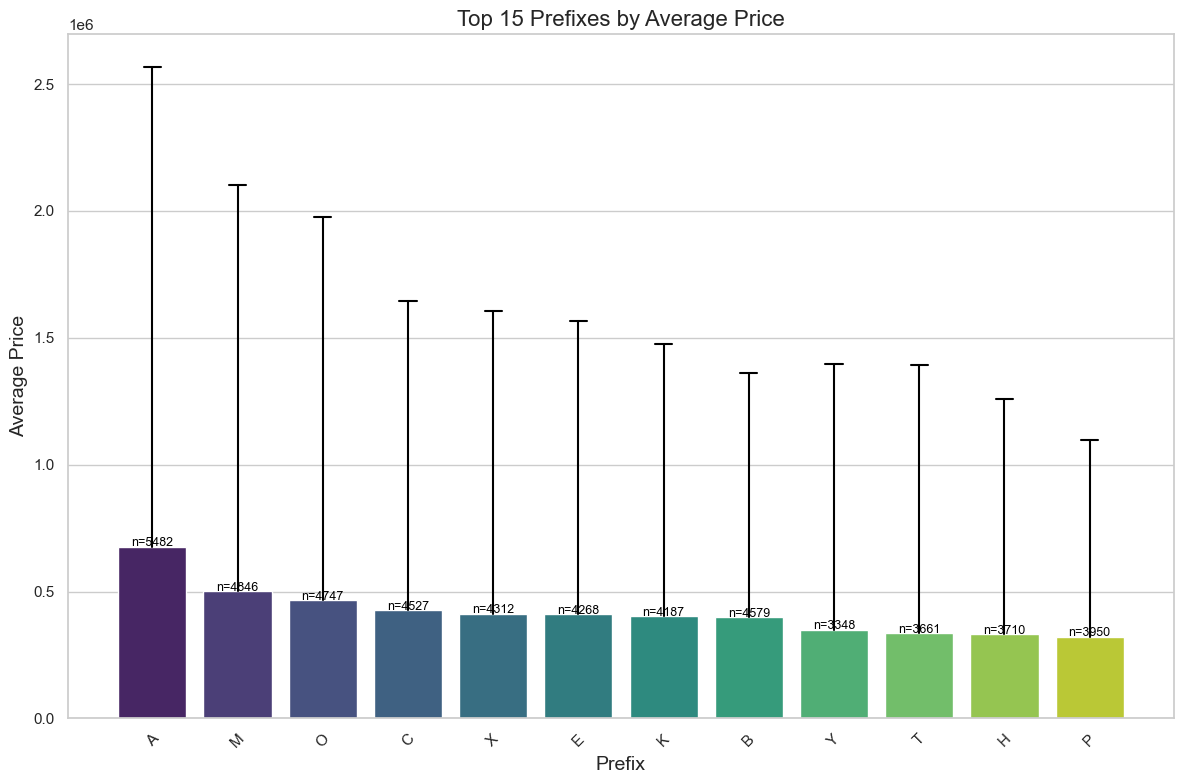

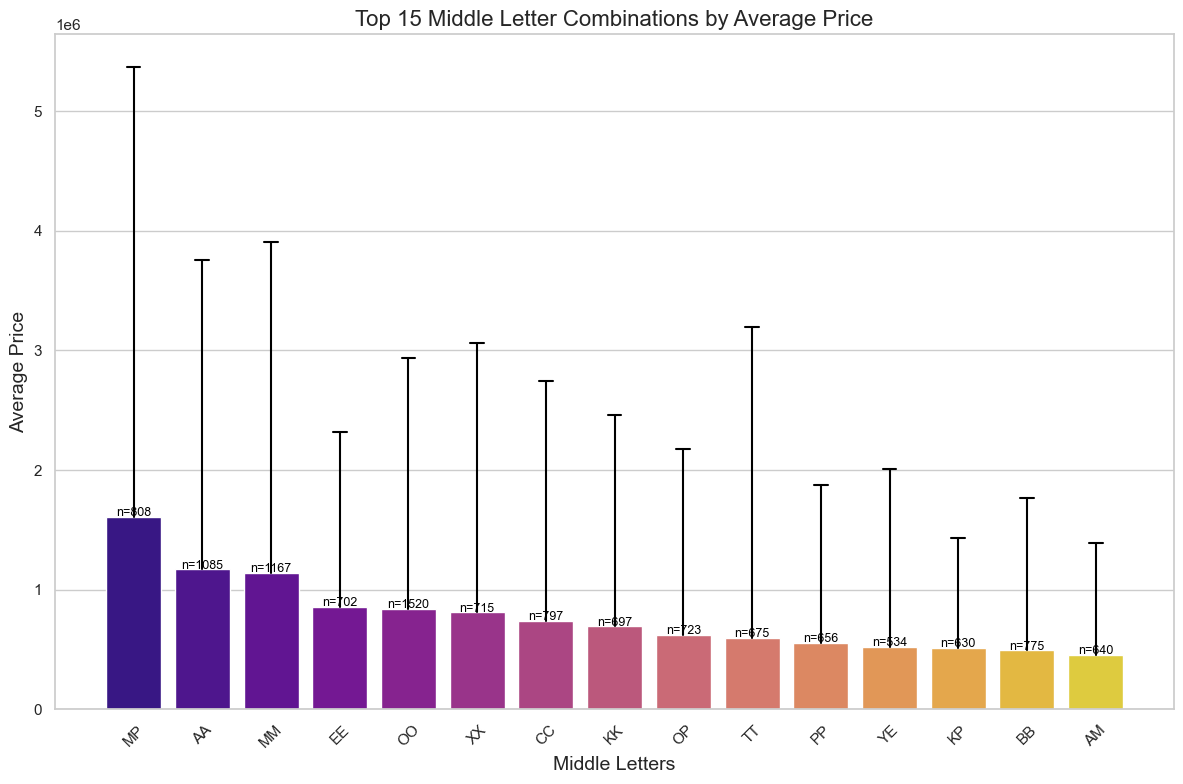

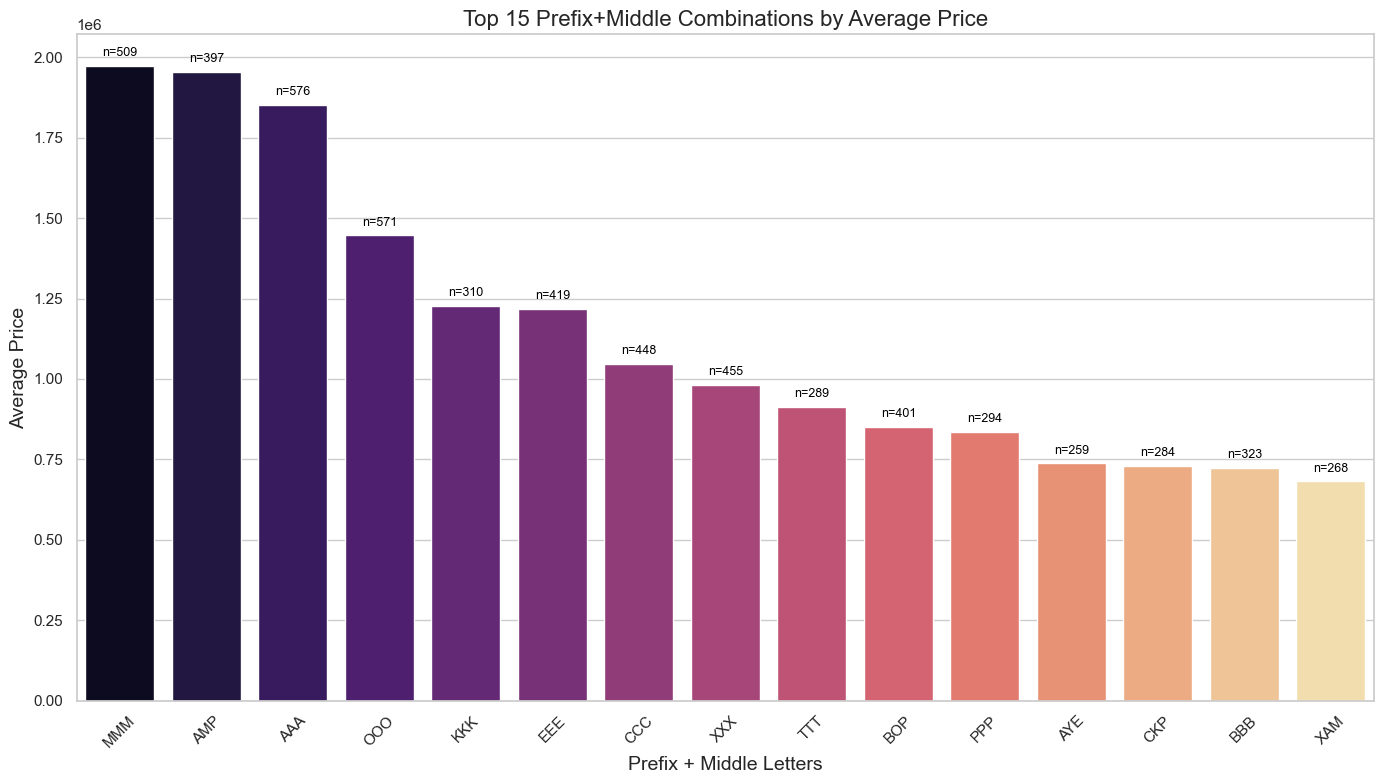

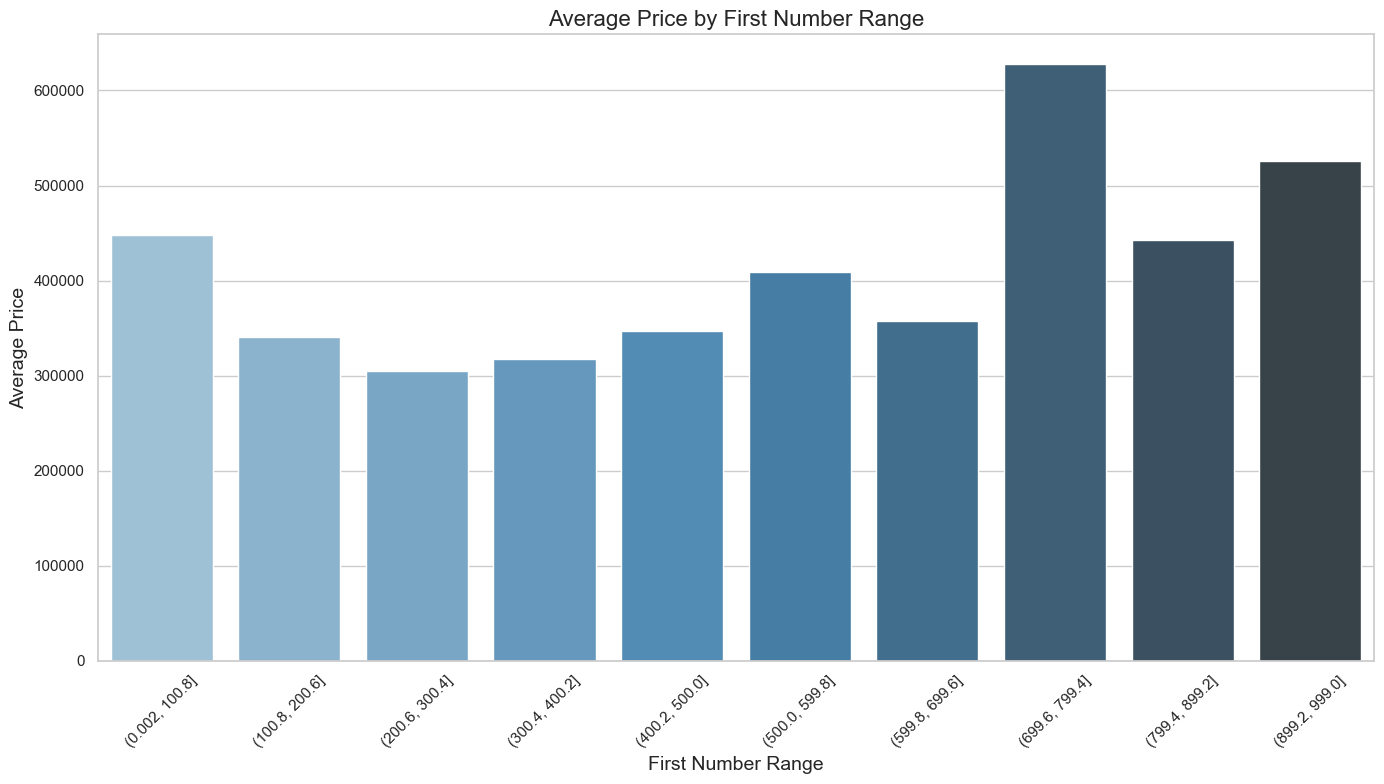

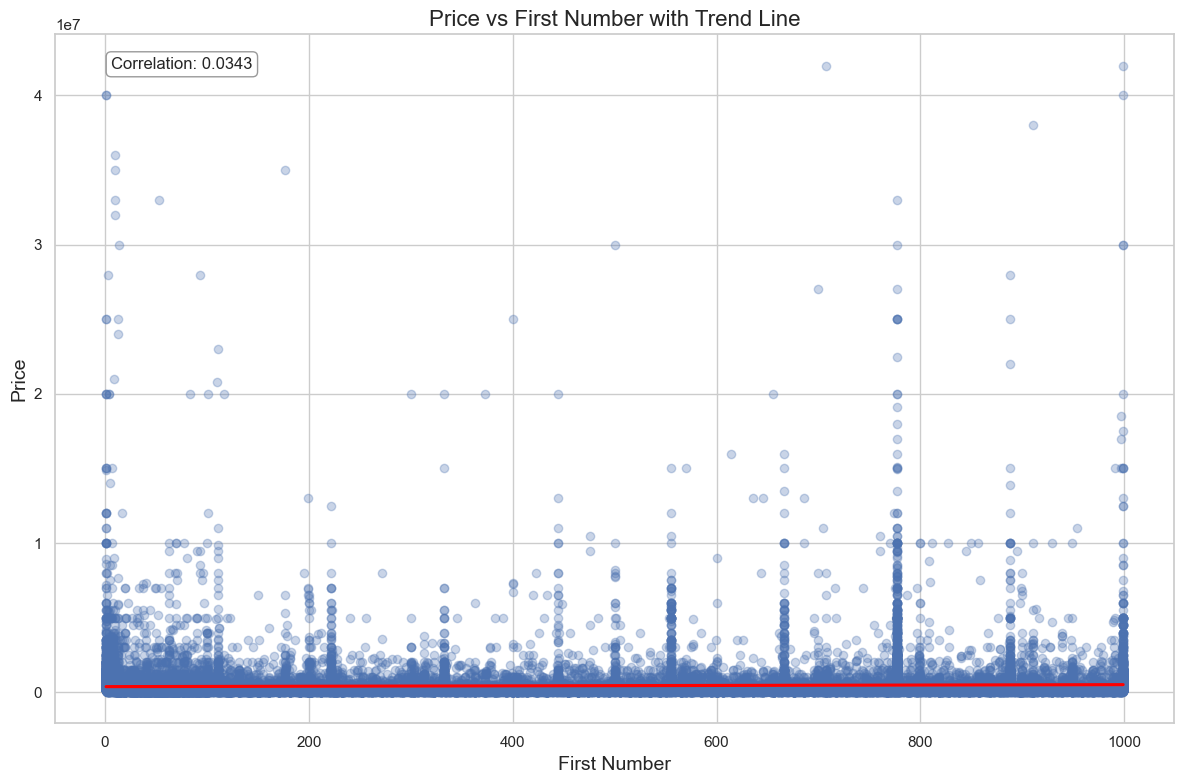

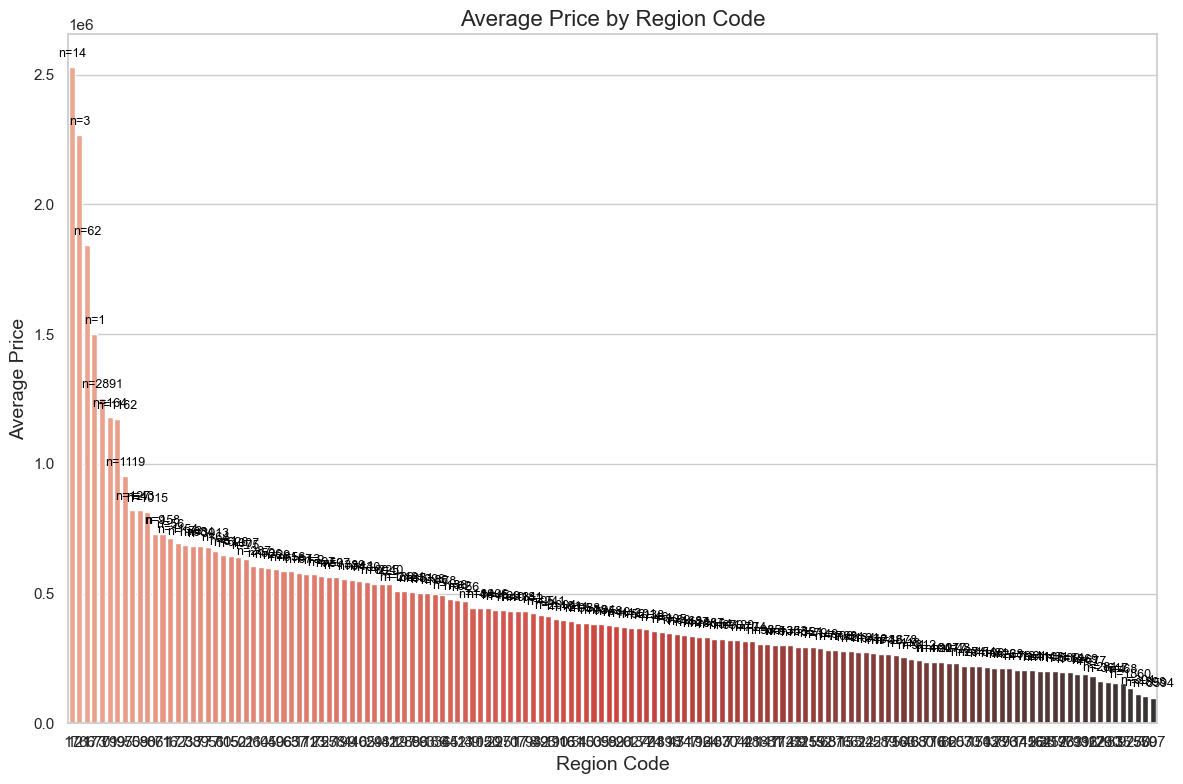

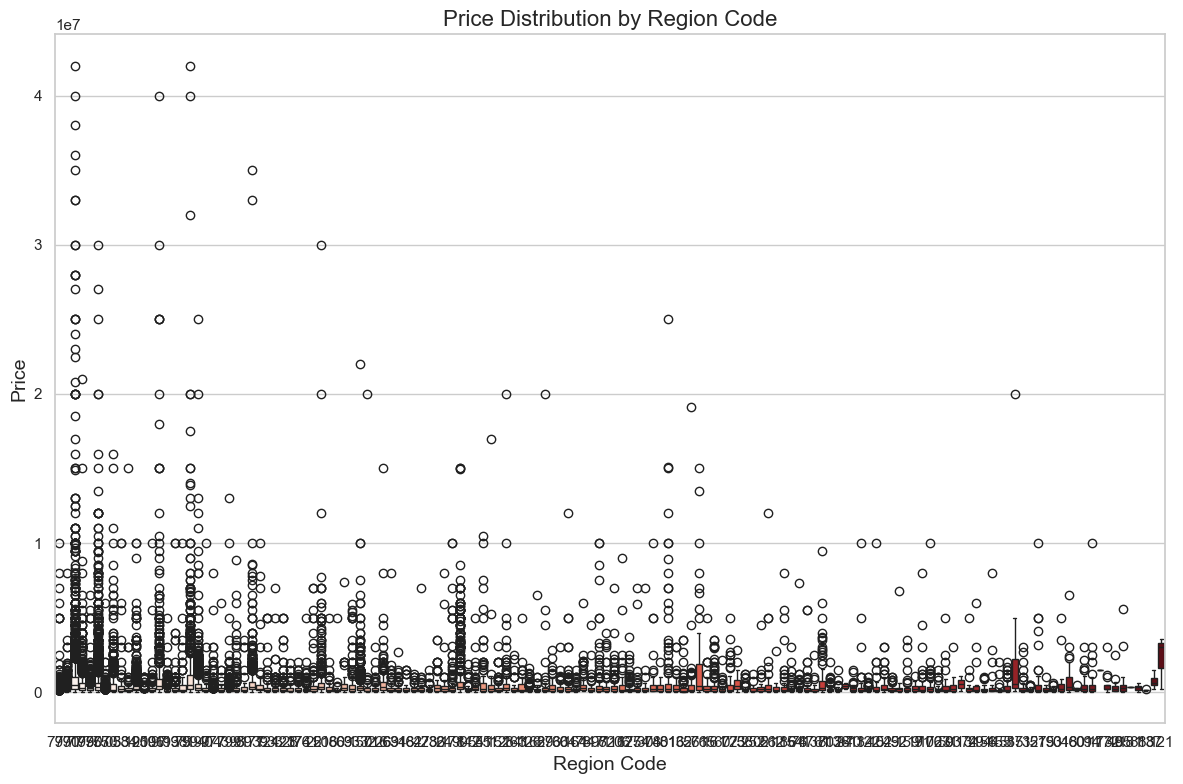

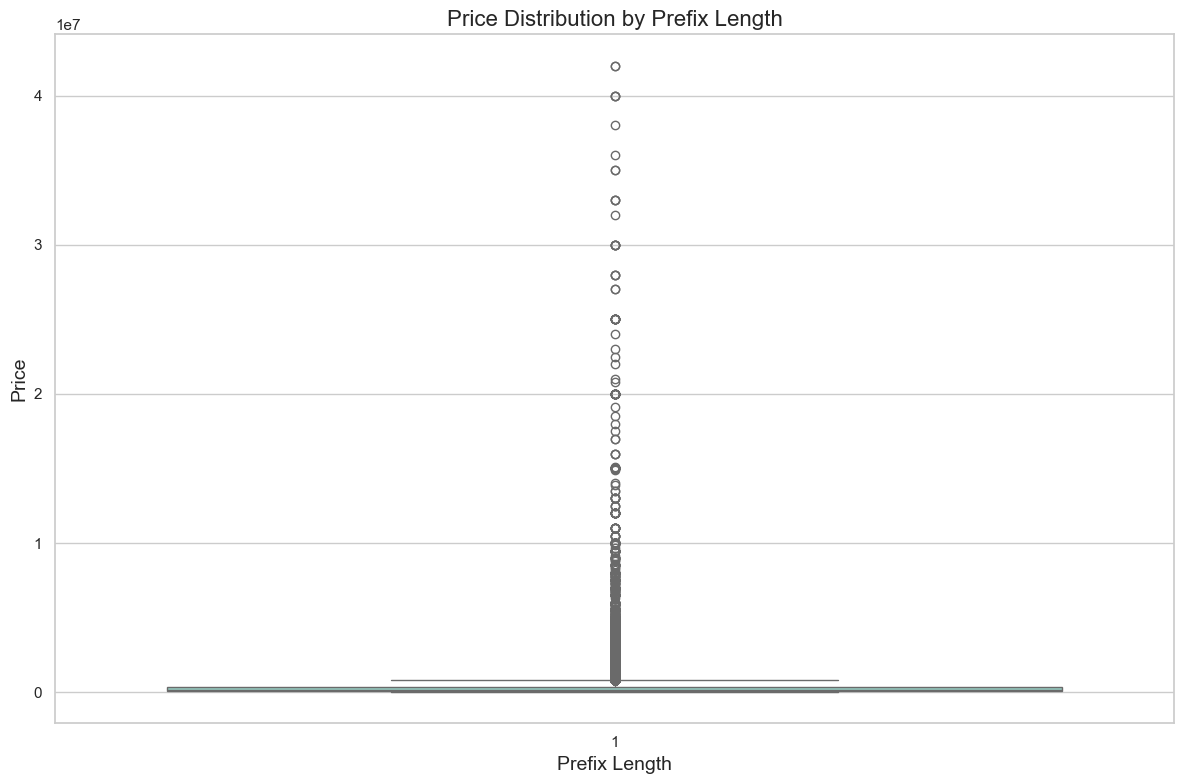

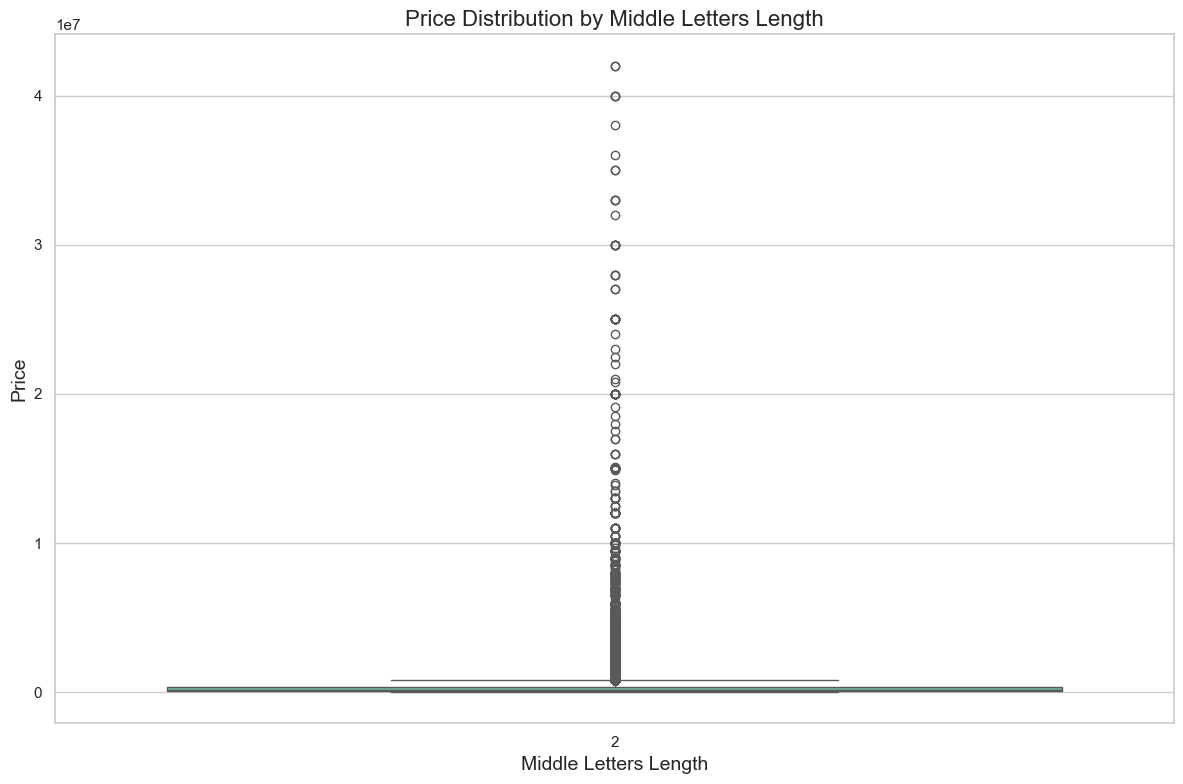

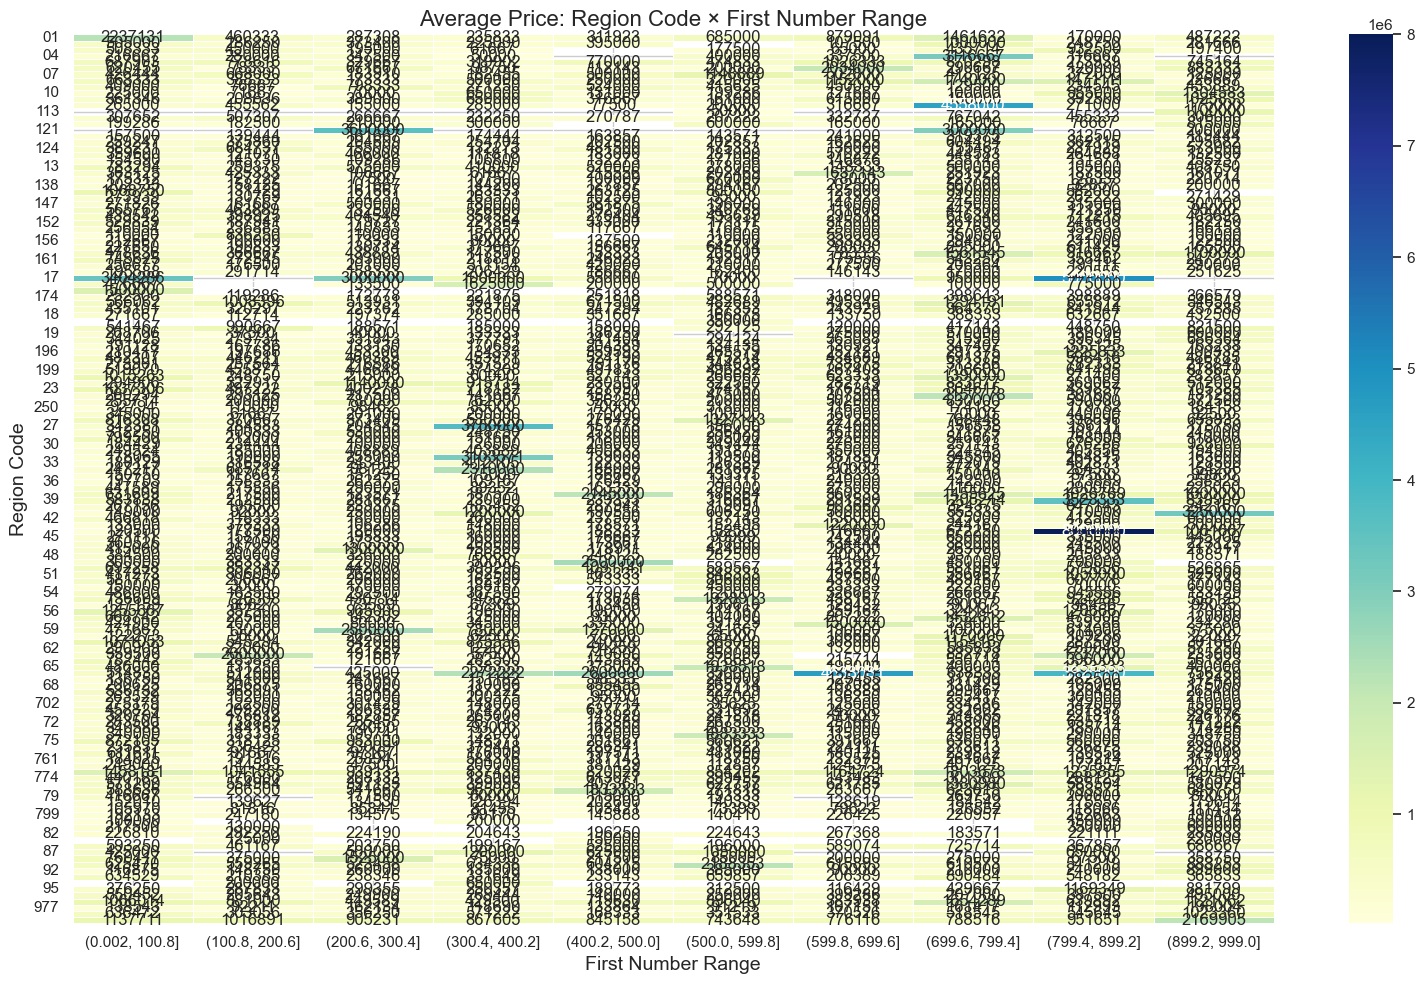

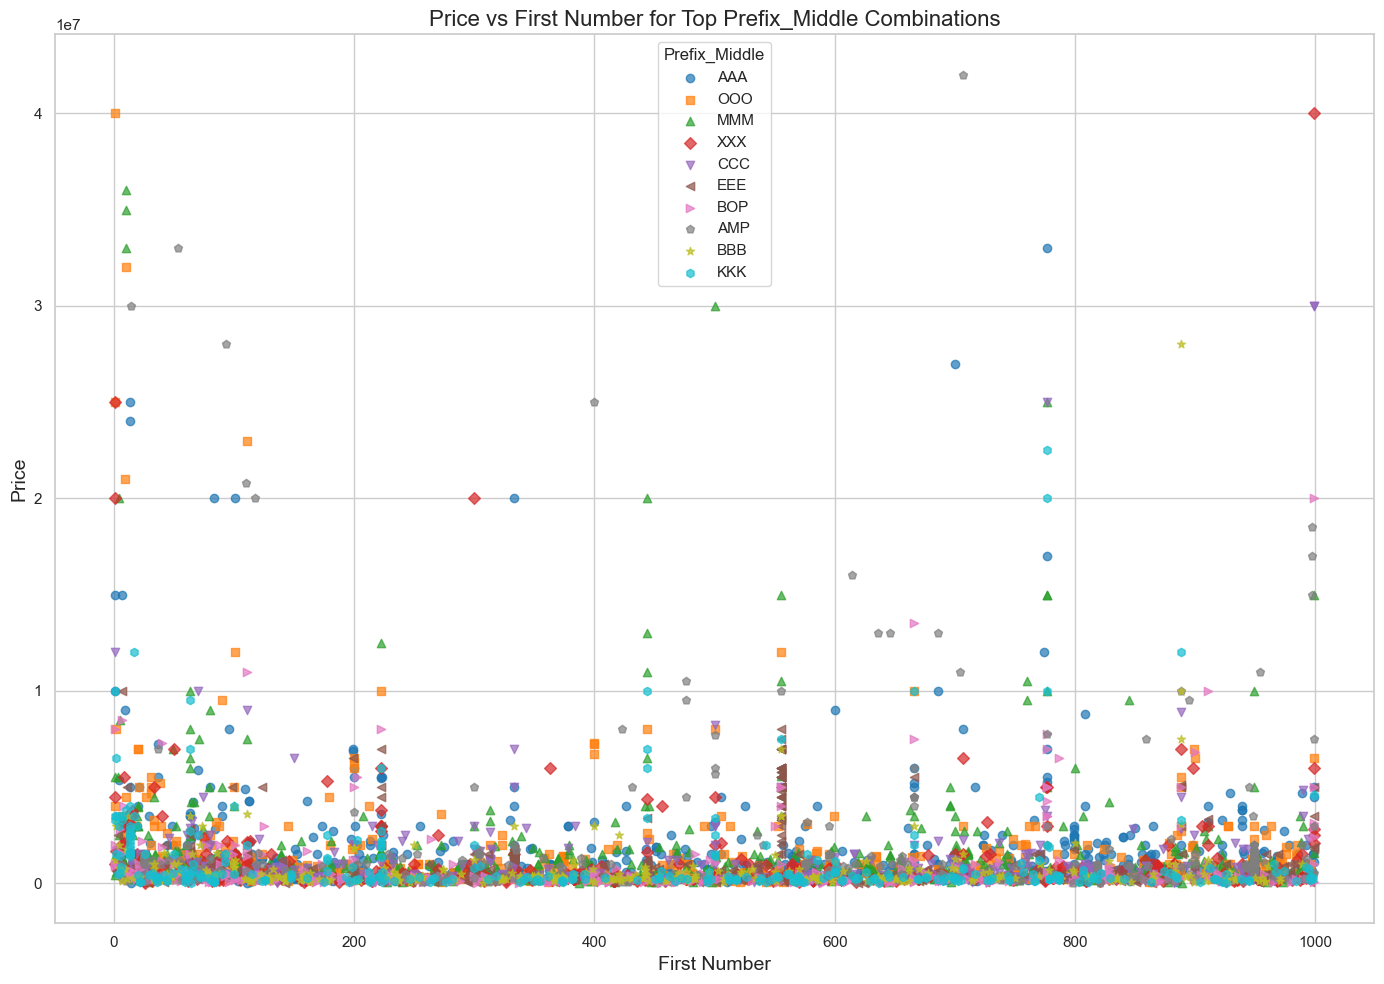

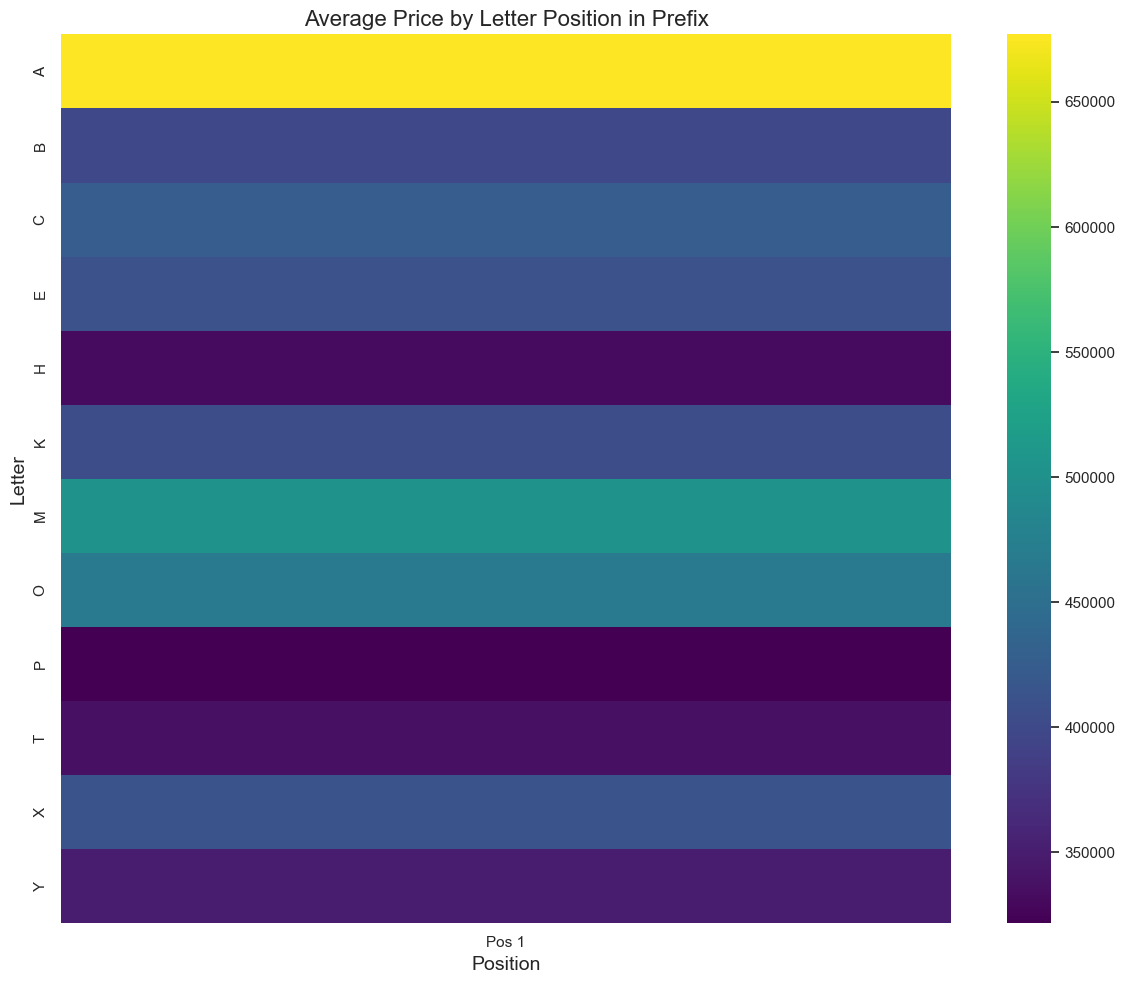

Analysis complete!

Data Overview:
Number of records: 51617
Columns: ['id', 'plate', 'price', 'price_transformed', 'prefix', 'first_number', 'middle_letters', 'Region_Code', 'year', 'month', 'day', 'code', 'region_name', 'prefix_middle', 'first_number_bin', 'prefix_len', 'middle_len']

Sample data:
   id      plate   price  price_transformed prefix  first_number  \
0   1  X059CP797   65000           4.169705      X            59   
1   2  Y800MH790  100000           4.206195      Y           800   
2   3   A212TX77  290000           4.282928      A           212   
3   4  P001AY199  680000           4.332700      P             1   
4   5  P001AY199  750000           4.337851      P             1   

  middle_letters Region_Code  year  month  day code    region_name  \
0             CP         797  2024     12   26  797         Moscow   
1             MH         790  2024      7   12  790  Moscow Oblast   
2             TX          77  2024      4   18   77         Moscow   
3          

C:\Users\avina\AppData\Local\Temp\ipykernel_14524\2869201612.py:122: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  first_num_stats = df.groupby(first_num_col)['price'].agg(['mean', 'median', 'count', 'std']).reset_index()
C:\Users\avina\AppData\Local\Temp\ipykernel_14524\2869201612.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_region_combo = df.groupby([first_num_col, 'Region_Code'])['price'].agg(['mean', 'count']).reset_index()
C:\Users\avina\AppData\Local\Temp\ipykernel_14524\2869201612.py:192: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

Individual Letter Price Correlation (top 10):
Letter 'M': Average Price = 599855.47
Letter 'A': Average Price = 558919.71
Letter 'O': Average Price = 477807.95
Letter 'P': Average Price = 430089.84
Letter 'E': Average Price = 420770.93
Letter 'X': Average Price = 403300.67
Letter 'K': Average Price = 401256.51
Letter 'C': Average Price = 393989.43
Letter 'B': Average Price = 365063.66
Letter 'Y': Average Price = 354863.30

--------------------------------------------------



C:\Users\avina\AppData\Local\Temp\ipykernel_14524\2869201612.py:276: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='prefix', y='mean', data=top_prefixes, palette='viridis', ax=ax1)
C:\Users\avina\AppData\Local\Temp\ipykernel_14524\2869201612.py:312: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='middle_letters', y='mean', data=top_middles, palette='plasma', ax=ax2)
C:\Users\avina\AppData\Local\Temp\ipykernel_14524\2869201612.py:348: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='prefix_middle', y='mean', data=top_c

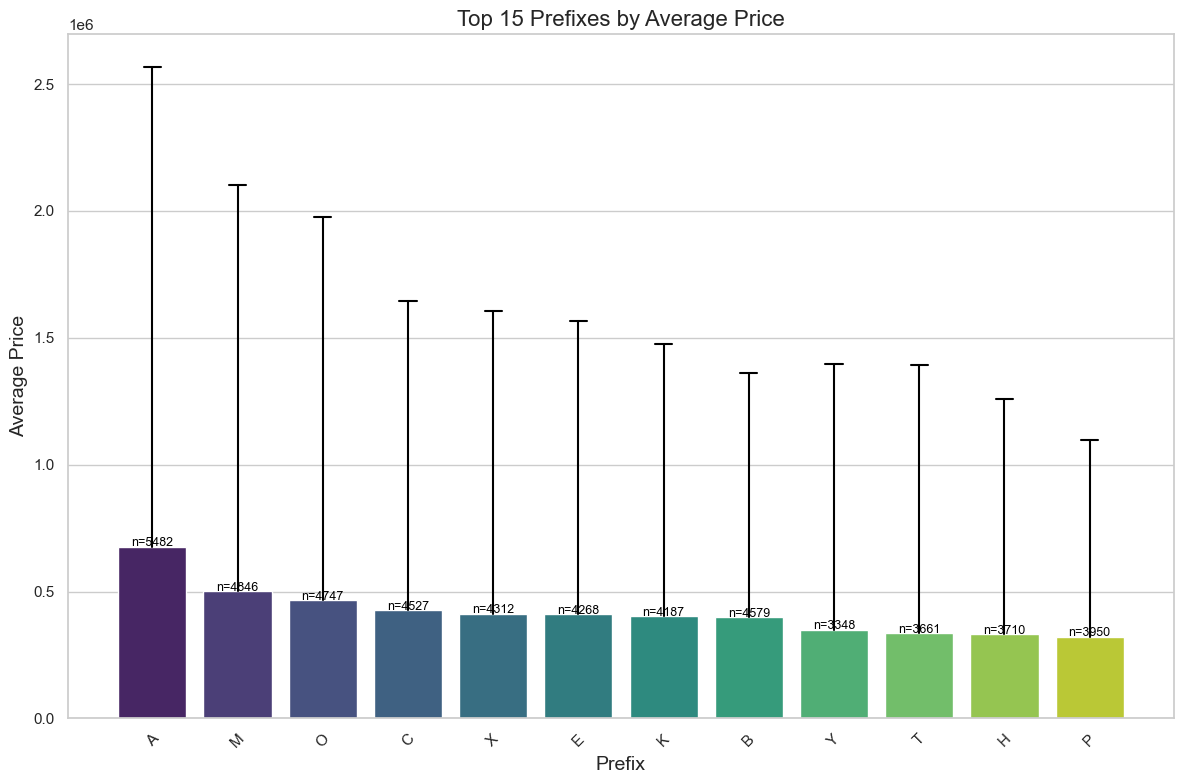

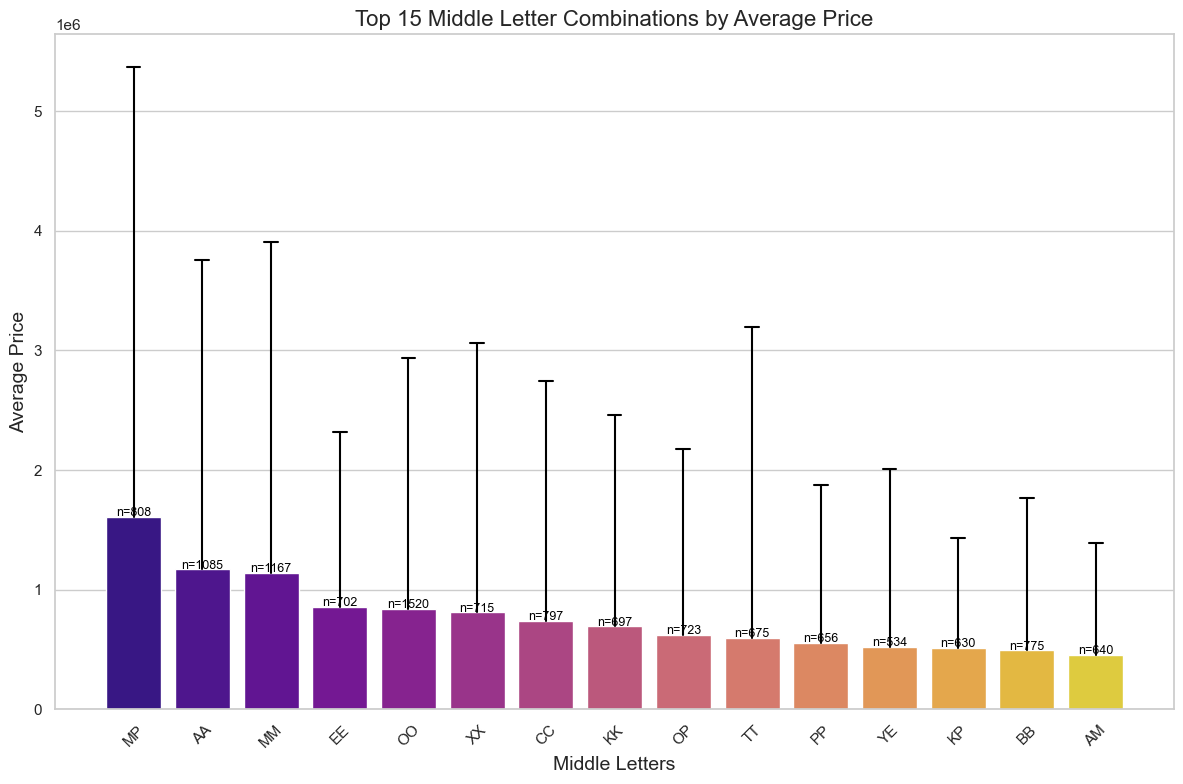

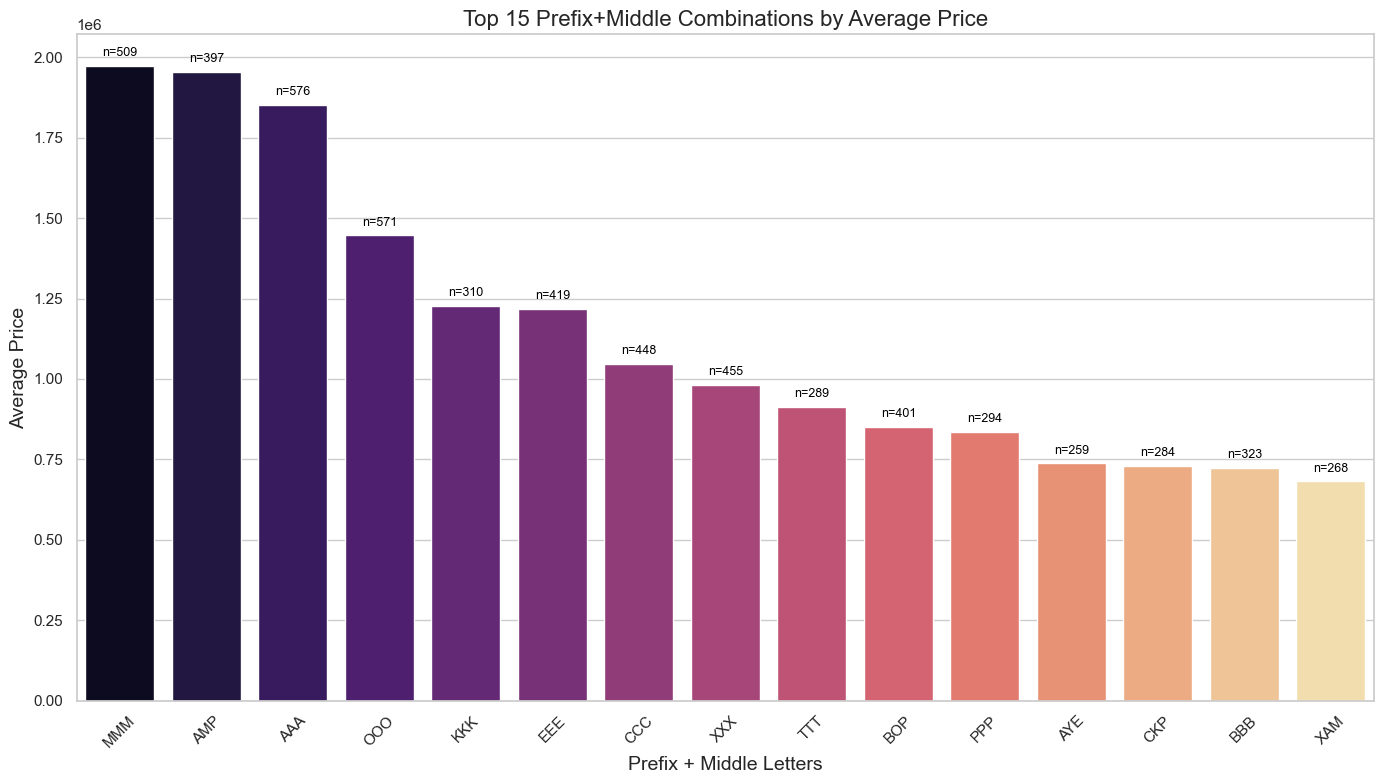

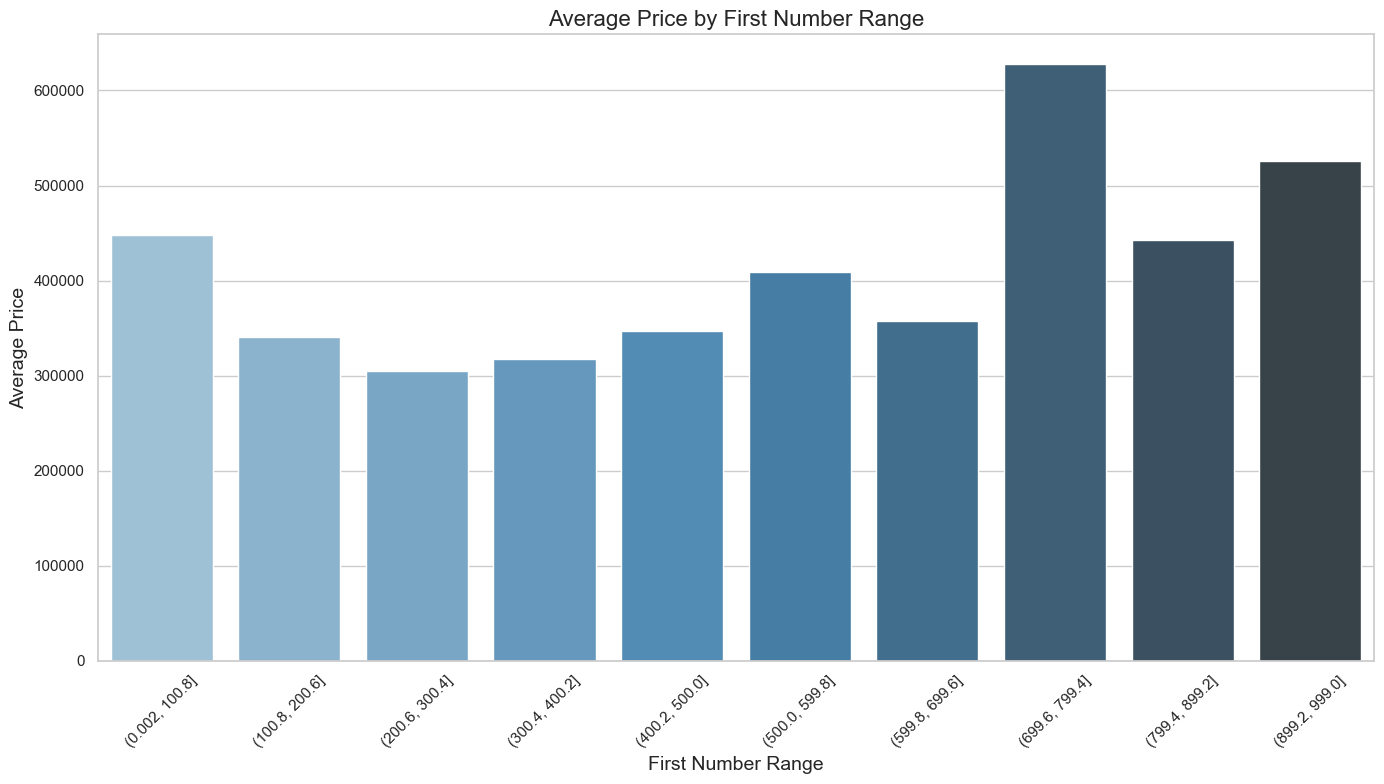

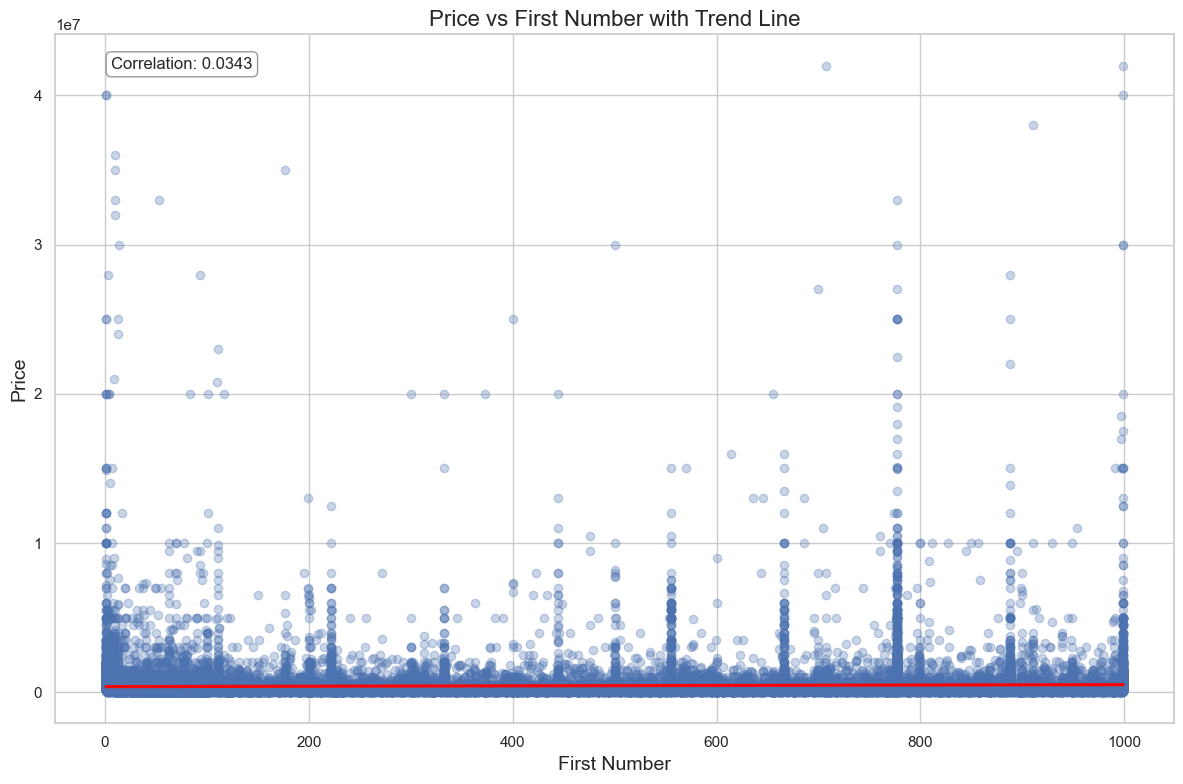

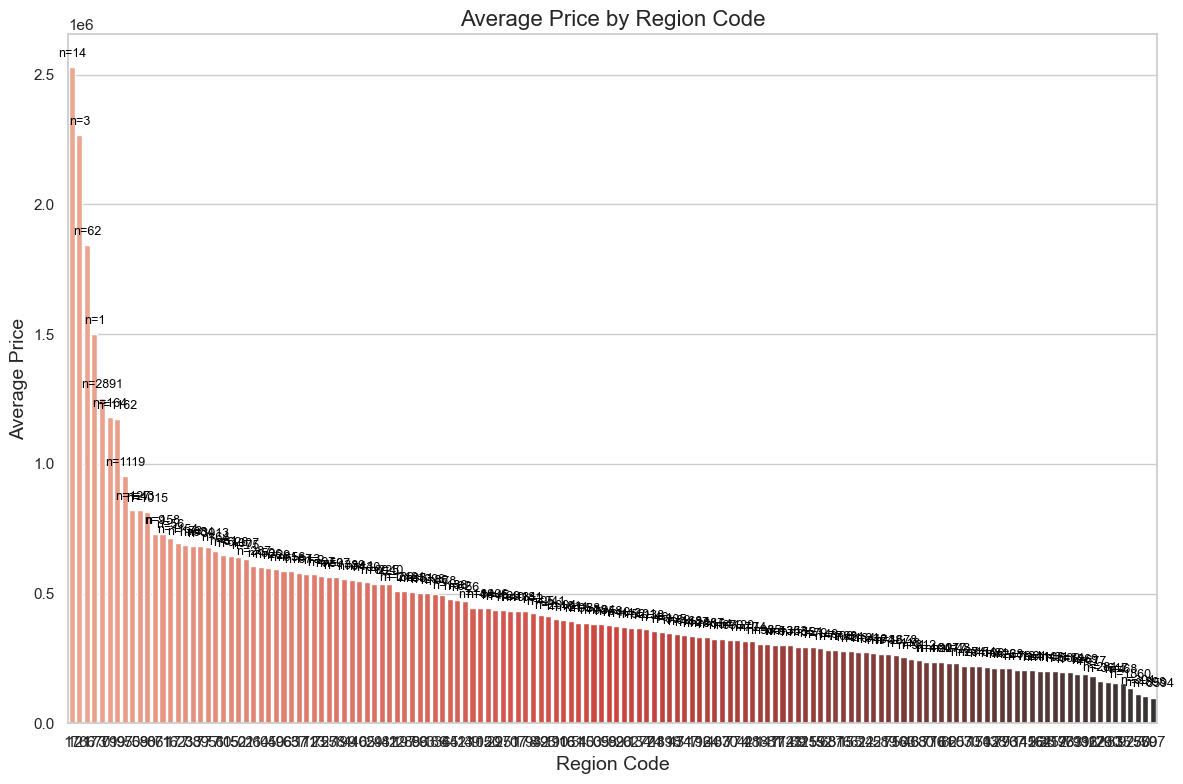

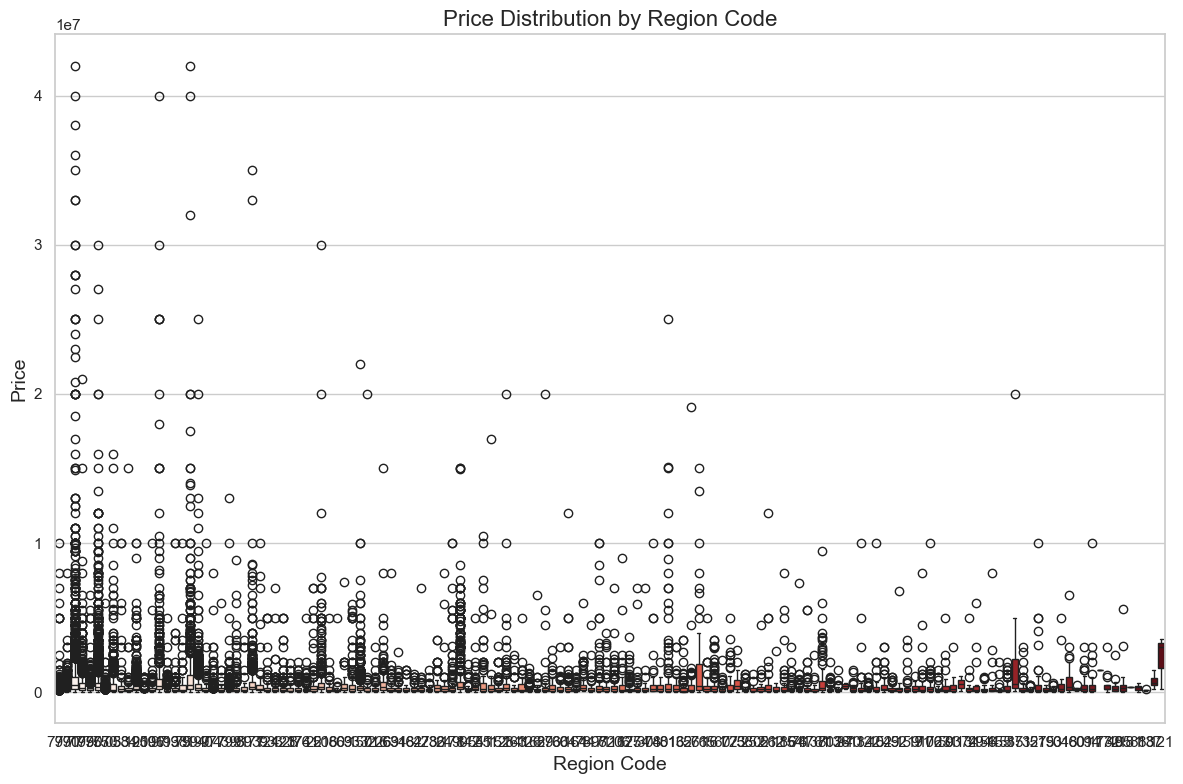

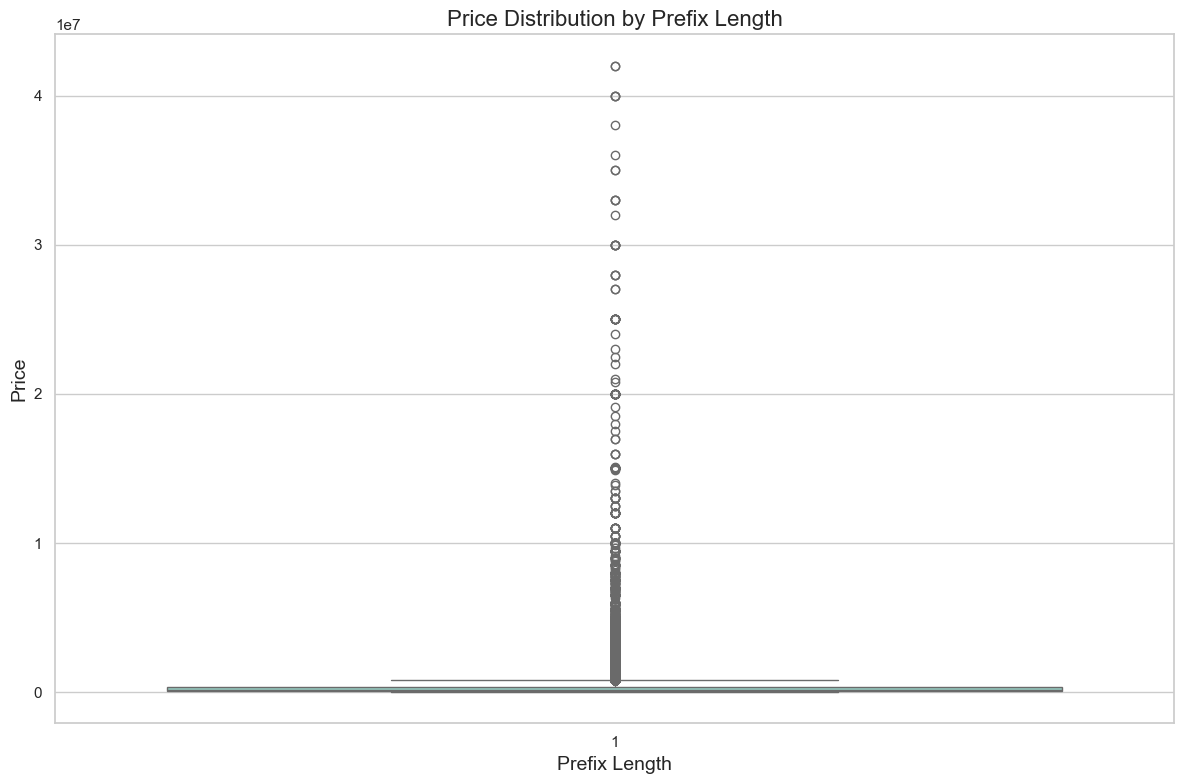

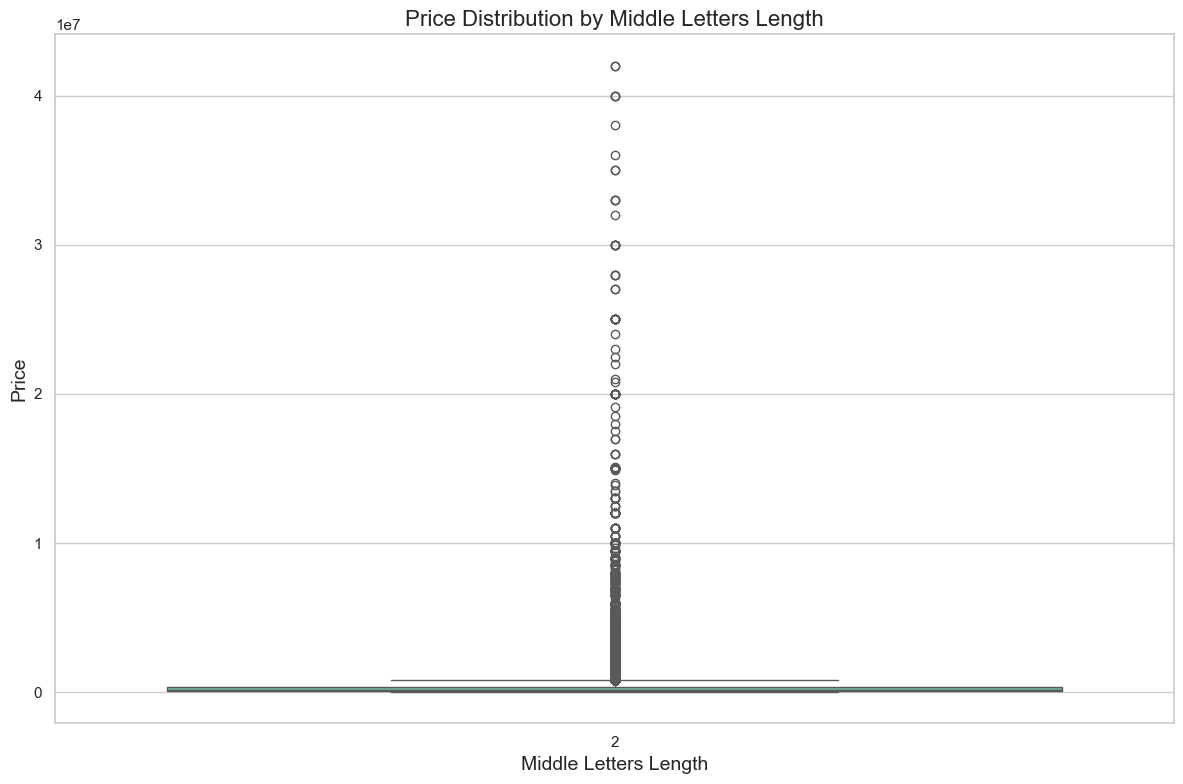

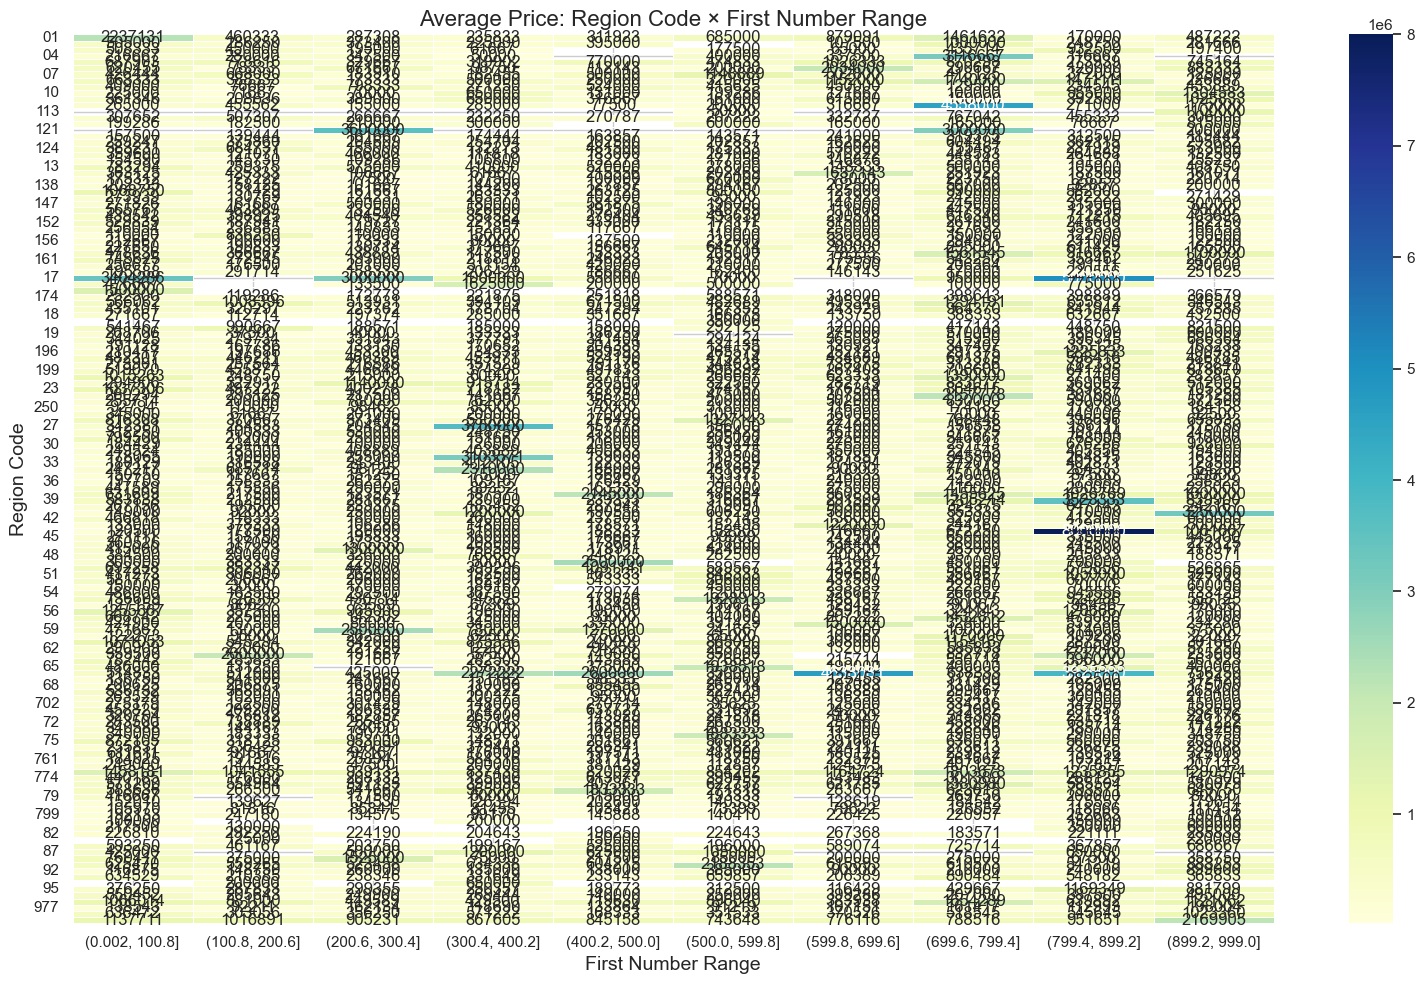

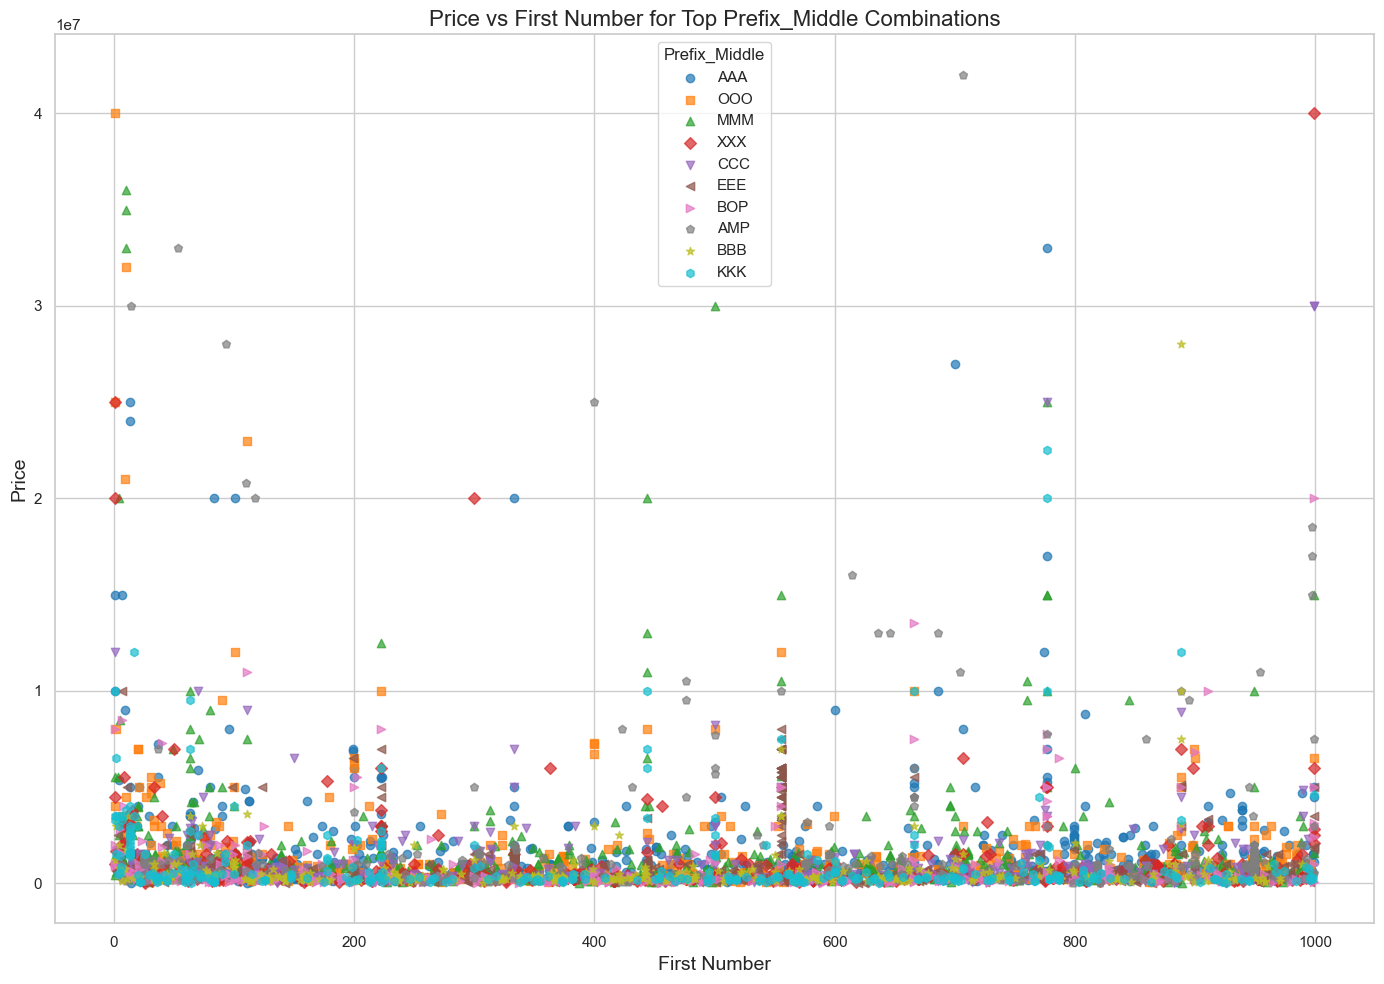

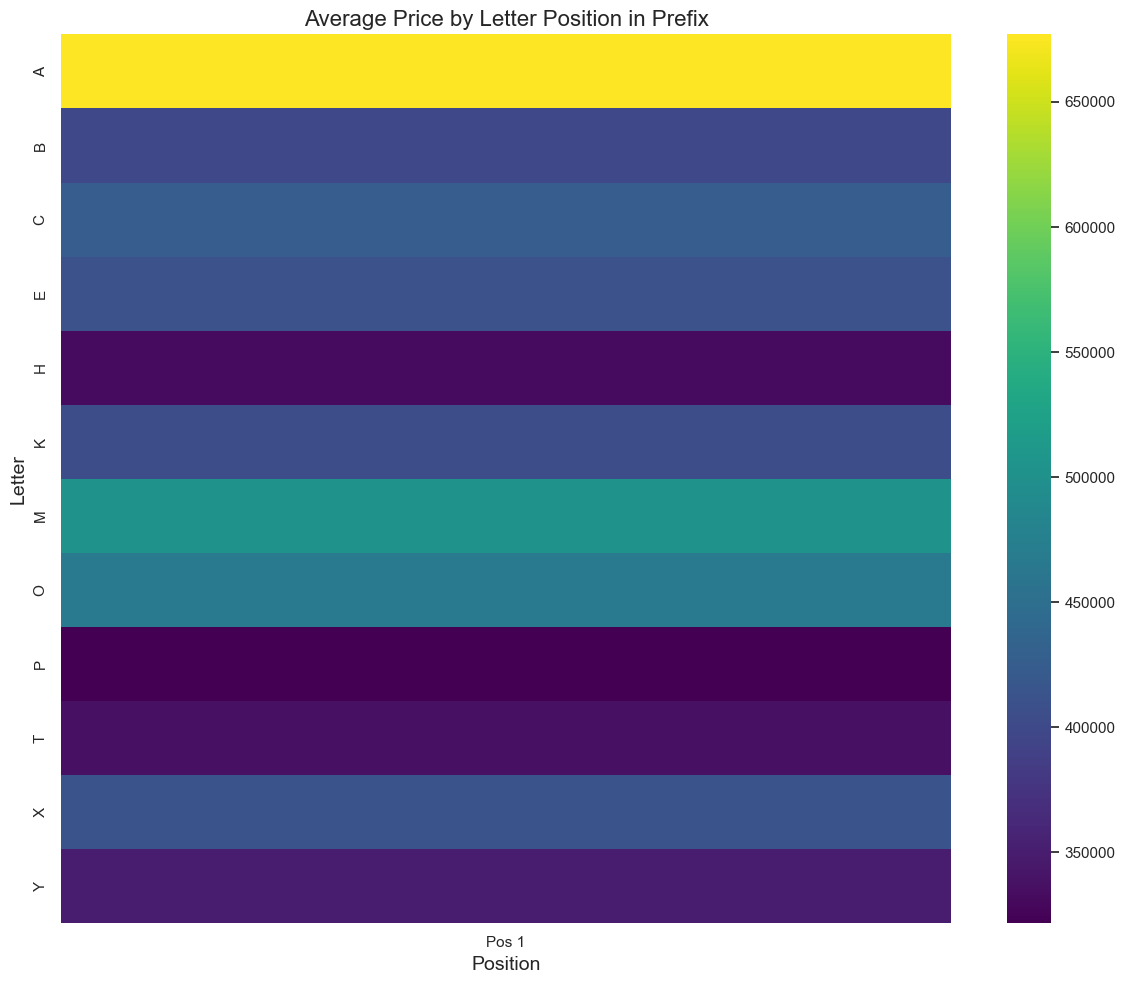

Analysis complete!


In [14]:
try:
    df = result
    print(f"Using results_df with {len(df)} records")
except NameError:
    print("results_df not found, please ensure the dataframe is loaded properly")
    exit(1)
    
# Print data overview
print("\nData Overview:")
print(f"Number of records: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print("\nSample data:")
print(df.head())
    
# Run analysis and visualization
results, figures = analyze_and_visualize_plate_prices(df)
    
# Display plots
for fig_name, fig in figures.items():
    plt.figure(fig.number)
    plt.tight_layout()
        
    # Uncomment to save figures
    # plt.savefig(f"{fig_name}.png", dpi=300, bbox_inches='tight')
    
plt.show()
    
print("Analysis complete!")
# Print data overview
print("\nData Overview:")
print(f"Number of records: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print("\nSample data:")
print(df.head())
    
# Run analysis and visualization
results, figures = analyze_and_visualize_plate_prices(df)
    
# Display plots
for fig_name, fig in figures.items():
    plt.figure(fig.number)
    plt.tight_layout()
        
    # Uncomment to save figures
    # plt.savefig(f"{fig_name}.png", dpi=300, bbox_inches='tight')
    
plt.show()
    
print("Analysis complete!")

In [15]:

import pickle
import json

def create_region_score_mapping(train_df, top_score=15, top_n=10, num_groups=5):
    """
    Create and save the region-to-score mapping based on training data.
    This should be run ONCE during training phase.
    
    Parameters:
    -----------
    train_df : DataFrame
        Training data with 'Region_Code' and 'price' columns
    top_score : int
        The highest score to assign (default: 15)
    top_n : int
        Number of top regions to score individually (default: 10)
    num_groups : int
        Number of groups for remaining regions (scored 5 to 1)
        
    Returns:
    --------
    dict
        Mapping of Region_Code to region_value_score
    """
    # Calculate average price by region
    region_price = train_df.groupby('Region_Code')['price'].mean().reset_index()
    
    # Sort by average price in descending order
    region_price = region_price.sort_values('price', ascending=False)
    
    # Create a dictionary to map Region_Code to score
    region_score_map = {}
    
    # Assign scores to top N regions (top_score down to 6)
    for i, region in enumerate(region_price['Region_Code'].head(top_n)):
        region_score_map[region] = top_score - i
    
    # Get the remaining regions
    remaining_regions = region_price['Region_Code'].iloc[top_n:].tolist()
    total_remaining = len(remaining_regions)
    
    # Calculate regions per group
    regions_per_group = total_remaining // num_groups
    remainder = total_remaining % num_groups
    
    # Assign scores to remaining regions in groups
    start_idx = 0
    for group_score in range(num_groups, 0, -1):  # From 5 down to 1
        # Adjust group size to distribute remainder
        group_size = regions_per_group + (1 if (num_groups - group_score) < remainder else 0)
        
        # Get regions for this group
        end_idx = start_idx + group_size
        group_regions = remaining_regions[start_idx:end_idx]
        
        # Assign score to all regions in this group
        for region in group_regions:
            region_score_map[region] = group_score
            
        start_idx = end_idx
    
    return region_score_map

def save_region_score_mapping(region_score_map, filepath):
    """
    Save the region score mapping to a file.
    
    Parameters:
    -----------
    region_score_map : dict
        The mapping dictionary from create_region_score_mapping()
    filepath : str
        Path to save the mapping (e.g., 'region_scores.pkl' or 'region_scores.json')
    """
    if filepath.endswith('.pkl'):
        with open(filepath, 'wb') as f:
            pickle.dump(region_score_map, f)
    elif filepath.endswith('.json'):
        with open(filepath, 'w') as f:
            json.dump(region_score_map, f)
    else:
        raise ValueError("Filepath must end with .pkl or .json")

def load_region_score_mapping(filepath):
    """
    Load the region score mapping from a file.
    
    Parameters:
    -----------
    filepath : str
        Path to the mapping file
        
    Returns:
    --------
    dict
        The region score mapping
    """
    if filepath.endswith('.pkl'):
        with open(filepath, 'rb') as f:
            return pickle.load(f)
    elif filepath.endswith('.json'):
        with open(filepath, 'r') as f:
            return json.load(f)
    else:
        raise ValueError("Filepath must end with .pkl or .json")

def apply_region_scores(df, region_score_map, default_score=1):
    """
    Apply region scores to any DataFrame (training or testing).
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with 'Region_Code' column
    region_score_map : dict
        Mapping of Region_Code to scores (from create_region_score_mapping)
    default_score : int
        Score to assign to regions not seen in training (default: 1)
        
    Returns:
    --------
    DataFrame
        DataFrame with added 'region_value_score' column
    """
    result_df = df.copy()
    
    # Apply the mapping, using default_score for unseen regions
    result_df['region_value_score'] = result_df['Region_Code'].map(region_score_map).fillna(default_score)
    
    # Convert to int to match original scores
    result_df['region_value_score'] = result_df['region_value_score'].astype(int)
    
    return result_df

# =============================================================================
# USAGE EXAMPLE
# =============================================================================

def example_workflow():
    """
    Example of how to use this system in training and testing phases.
    """
    
    # ==================
    # TRAINING PHASE
    # ==================
    print("=== TRAINING PHASE ===")
    
    # Assume you have your training data
    # train_df = pd.read_csv('train_data.csv')
    
    # 1. Create the region score mapping based on training data
    region_scores = create_region_score_mapping(train_df, top_score=15, top_n=10, num_groups=5)
    
    # 2. Save the mapping for later use
    save_region_score_mapping(region_scores, 'region_scores.pkl')
    
    # 3. Apply scores to training data
    train_df_scored = apply_region_scores(train_df, region_scores)
    
    print("Training phase complete. Region scores saved.")
    print(f"Total regions mapped: {len(region_scores)}")
    
    # ==================
    # TESTING PHASE
    # ==================
    print("\n=== TESTING PHASE ===")
    
    # Assume you have your test data
    # test_df = pd.read_csv('test_data.csv')
    
    # 1. Load the saved region score mapping
    region_scores = load_region_score_mapping('region_scores.pkl')
    
    # 2. Apply the same scores to test data
    test_df_scored = apply_region_scores(test_df, region_scores, default_score=1)
    
    print("Testing phase complete. Same region scores applied to test data.")
    
    # Check for any new regions in test data
    test_regions = set(test_df['Region_Code'].unique())
    train_regions = set(region_scores.keys())
    new_regions = test_regions - train_regions
    
    if new_regions:
        print(f"Warning: {len(new_regions)} new regions found in test data: {new_regions}")
        print("These regions received the default score of 1.")
    
    return train_df_scored, test_df_scored

# =============================================================================
# ANALYSIS FUNCTIONS
# =============================================================================

def analyze_region_scores(df_with_scores, region_score_map):
    """
    Analyze the distribution of region scores in your data.
    """
    # Score distribution
    score_dist = df_with_scores['region_value_score'].value_counts().sort_index(ascending=False)
    
    print("Region Score Distribution:")
    print("=========================")
    for score, count in score_dist.items():
        regions_with_score = [k for k, v in region_score_map.items() if v == score]
        print(f"Score {score}: {count} records from {len(regions_with_score)} regions")
        if len(regions_with_score) <= 5:
            print(f"  Regions: {regions_with_score}")
        else:
            print(f"  Example regions: {regions_with_score[:3]}...")
        print()

def get_region_score_summary(region_score_map):
    """
    Get a summary of the region scoring system.
    """
    score_summary = {}
    for region, score in region_score_map.items():
        if score not in score_summary:
            score_summary[score] = []
        score_summary[score].append(region)
    
    print("Region Score Summary:")
    print("====================")
    for score in sorted(score_summary.keys(), reverse=True):
        regions = score_summary[score]
        print(f"Score {score}: {len(regions)} regions")
        if len(regions) <= 5:
            print(f"  All regions: {regions}")
        else:
            print(f"  Example regions: {regions[:3]}...")
        print()
    
    return score_summary

In [16]:
# Create and save the mapping based on training data
region_scores = create_region_score_mapping(result)
save_region_score_mapping(region_scores, 'region_scores1.pkl')

In [17]:
result_scored = apply_region_scores(result, region_scores)

In [18]:
from supplemental_english import GOVERNMENT_CODES
import math
from collections import Counter

LOOKUP_GOV_CODES = {}
for (prefix_middle, num_range, region), (name, is_forbidden, has_advantage, significance) in GOVERNMENT_CODES.items():
    LOOKUP_GOV_CODES[(prefix_middle, region)] = (num_range, is_forbidden, has_advantage, significance, name)

def get_gov_features(prefix: str, number: int, region_code: str):
    """Get government related features for a license plate."""
    key = (prefix, region_code)
    if key in LOOKUP_GOV_CODES:
        num_range, is_forbidden, has_advantage, significance, name = LOOKUP_GOV_CODES[key]
        if num_range[0] <= number <= num_range[1]:
            return is_forbidden, has_advantage, significance, name
    return 0, 0, 0, ""

def has_repeated_digits(n):
    """Check if the number has any repeated digits."""
    digits = str(n).zfill(3)
    return int(len(set(digits)) < len(digits))

def is_palindrome(n):
    """Check if the number reads the same backward as forward."""
    s = str(n).zfill(3)
    return int(s == s[::-1])

def is_special_number(n):
    """Check if the number follows special patterns."""
    s = str(n).zfill(3)
    special_sequences = ['123', '321', '111', '222', '777', '234', '432', '678', '876']
    
    # Check for special patterns
    is_all_same = len(set(s)) == 1  # All digits same
    is_front_same = s[0] == s[1]    # First two digits same
    is_end_same = s[1] == s[2]      # Last two digits same
    is_mirror = s[0] == s[2]        # First and last digits same
    
    return int(is_all_same or is_front_same or is_end_same or is_mirror or s in special_sequences)

def _is_arithmetic_sequence(s):
    """Check if the digits form an arithmetic sequence."""
    digits = [int(c) for c in s]
    if len(digits) <= 1:
        return False
    diff = digits[1] - digits[0]
    return all(digits[i] - digits[i-1] == diff for i in range(1, len(digits)))

# NEW: Count zeros in the number
def count_zeros_in_number(n):
    """
    Count zeros in the first_number and return score based on zero count.
    Returns 1 if exactly 2 zeros, 1 if exactly 1 zero, 0 if no zeros.
    """
    s = str(n).zfill(3)
    zero_count = s.count('0')
    
    if zero_count == 2:
        return 1
    elif zero_count == 1:
        return 1
    else:
        return 0

# NEW: Check for continuous increasing or decreasing sequences
def is_continuous_sequence(n):
    """
    Check if the number has continuously increasing or decreasing digits.
    Examples: 123, 234, 345, 456, 567, 678, 789 (increasing)
             321, 432, 543, 654, 765, 876, 987 (decreasing)
    Returns 1 if continuous sequence found, 0 otherwise.
    """
    s = str(n).zfill(3)
    digits = [int(d) for d in s]
    
    # Check for continuous increasing (each digit is exactly 1 more than previous)
    is_continuous_increasing = all(digits[i] == digits[i-1] + 1 for i in range(1, len(digits)))
    
    # Check for continuous decreasing (each digit is exactly 1 less than previous)
    is_continuous_decreasing = all(digits[i] == digits[i-1] - 1 for i in range(1, len(digits)))
    
    return int(is_continuous_increasing or is_continuous_decreasing)

# Functions for assigning values to license plate components
def assign_prefix_value(prefix):
    """
    Assign value to license plate prefix.
    A has highest value, followed by M, O, C, X, E, K, B.
    All others are given 0.
    """
    prefix_values = {
        'A': 8,
        'M': 7,
        'O': 6,
        'C': 5,
        'X': 4,
        'E': 3,
        'K': 2,
        'B': 1
    }
    # Return the value if prefix exists in the dictionary, otherwise return 0
    return prefix_values.get(prefix, 0)

def assign_middle_letters_value(middle_letters):
    """
    Assign value to license plate middle letters.
    MP has highest value, followed by AA, MM, EE, OO, XX, CC, KK, OP, TT, PP, YE, KP, BB, AM.
    All others are given 0.
    """
    middle_letters_values = {
        'MP': 15,
        'AA': 14,
        'MM': 13,
        'EE': 12,
        'OO': 11,
        'XX': 10,
        'CC': 9,
        'KK': 8,
        'OP': 7,
        'TT': 6,
        'PP': 5,
        'YE': 4,
        'KP': 3,
        'BB': 2,
        'AM': 1
    }
    # Return the value if middle_letters exists in the dictionary, otherwise return 0
    return middle_letters_values.get(middle_letters, 0)

def assign_prefix_middle_value(prefix_middle):
    """
    Assign value to combined prefix and middle letters.
    MMM has highest value, followed by AMP, AAA, OOO, KKK, EEE, CCC, XXX, TTT, BCP, PPP, AYE, CKP, BBB.
    All others are given 0.
    """
    prefix_middle_values = {
        'MMM': 14,
        'AMP': 13,
        'AAA': 12,
        'OOO': 11,
        'KKK': 10,
        'EEE': 9,
        'CCC': 8,
        'XXX': 7,
        'TTT': 6,
        'BCP': 5,
        'PPP': 4,
        'AYE': 3,
        'CKP': 2,
        'BBB': 1
    }
    # Return the value if prefix_middle exists in the dictionary, otherwise return 0
    return prefix_middle_values.get(prefix_middle, 0)

# NEW: Enhanced value assignment based on regional significance
def assign_region_value(region_code):
    """
    Assign value to region codes based on their significance.
    Capital regions (77, 97, 99) have highest value, followed by major cities.
    """
    capital_regions = {'77': 10, '97': 9, '99': 8}
    major_cities = {'78': 7, '98': 7, '50': 6, '61': 5, '63': 5, '54': 5, '36': 4}
    
    # Return the value if region exists in the dictionaries, otherwise return lower values
    if region_code in capital_regions:
        return capital_regions[region_code]
    elif region_code in major_cities:
        return major_cities[region_code]
    else:
        return 1  # Base value for all other regions

# NEW: Check if the license plate has historically significant numbers
def has_historical_significance(number):
    """
    Check if the number holds historical significance in Russian context.
    Examples: 1917 (Revolution), 1941 (WWII start), 1945 (Victory), etc.
    """
    significant_years = [1917, 1941, 1945, 1961, 1991, 2000]
    
    # Check if the number is a historically significant year or part of it
    num_str = str(number).zfill(3)
    
    # Check if it's the last 3 digits of a significant year
    for year in significant_years:
        if num_str == str(year)[-3:]:
            return 1
    
    return 0

# NEW: Calculate rarity based on government code distribution
def calculate_govt_rarity(prefix_middle, first_number, region_code):
    """
    Calculate how rare a government plate is based on its distribution in the LOOKUP_GOV_CODES.
    """
    if (prefix_middle, region_code) not in LOOKUP_GOV_CODES:
        return 0
    
    num_range, is_forbidden, has_advantage, significance, _ = LOOKUP_GOV_CODES[(prefix_middle, region_code)]
    
    # Higher score for more restricted ranges
    range_size = num_range[1] - num_range[0] + 1
    if range_size <= 10:
        range_rarity = 5
    elif range_size <= 50:
        range_rarity = 4
    elif range_size <= 100:
        range_rarity = 3
    elif range_size <= 300:
        range_rarity = 2
    else:
        range_rarity = 1
    
    # Position within the range can also affect rarity
    position_in_range = (first_number - num_range[0]) / range_size
    
    # Numbers at the beginning of a range are often more prestigious
    if position_in_range <= 0.1:
        position_bonus = 2
    elif position_in_range <= 0.25:
        position_bonus = 1
    else:
        position_bonus = 0
        
    return range_rarity + position_bonus

# NEW: Check for auspicious or unlucky numbers in various cultures
def calculate_cultural_value(number):
    """
    Calculate cultural value of the number across different cultures.
    """
    num_str = str(number).zfill(3)
    
    # Lucky numbers in many cultures
    lucky_digits = {'7', '8', '3', '9'}
    
    # Unlucky numbers in some cultures
    unlucky_digits = {'4', '13'}
    
    lucky_count = sum(1 for digit in num_str if digit in lucky_digits)
    unlucky_count = sum(1 for digit in num_str if digit in unlucky_digits)
    
    # Check for specific lucky combinations
    lucky_combinations = ['888', '777', '999', '789', '168']
    unlucky_combinations = ['666', '444', '013', '004']
    
    if num_str in lucky_combinations:
        lucky_count += 3
    
    if num_str in unlucky_combinations:
        unlucky_count += 3
    
    return lucky_count - unlucky_count

# ADVANCED NUMERICAL FEATURES

def calculate_number_entropy(n):
    """Calculate Shannon entropy of digits in the number - measures randomness/unpredictability."""
    s = str(n).zfill(3)
    digit_counts = Counter(s)
    total = len(s)
    entropy = -sum((count/total) * math.log2(count/total) for count in digit_counts.values())
    return entropy

def is_fibonacci_related(n):
    """Check if number is related to Fibonacci sequence (contains Fibonacci digits or sums)."""
    fibonacci_nums = {0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987}
    
    # Check if number itself is Fibonacci
    if n in fibonacci_nums:
        return 2
    
    # Check if sum of digits is Fibonacci
    digit_sum = sum(int(d) for d in str(n).zfill(3))
    if digit_sum in fibonacci_nums:
        return 1
    
    return 0

def is_prime_related(n):
    """Check if the number or its digit sum is prime."""
    def is_prime(num):
        if num < 2:
            return False
        for i in range(2, int(num**0.5) + 1):
            if num % i == 0:
                return False
        return True
    
    # Check if number itself is prime
    if is_prime(n):
        return 2
    
    # Check if sum of digits is prime
    digit_sum = sum(int(d) for d in str(n).zfill(3))
    if is_prime(digit_sum):
        return 1
    
    return 0

def calculate_digit_harmonics(n):
    """Calculate harmonic mean of non-zero digits."""
    s = str(n).zfill(3)
    non_zero_digits = [int(d) for d in s if d != '0']
    
    if not non_zero_digits:
        return 0
    
    harmonic_mean = len(non_zero_digits) / sum(1/d for d in non_zero_digits)
    return harmonic_mean

def has_mathematical_pattern(n):
    """Check for advanced mathematical patterns (powers, squares, cubes, etc.)."""
    s = str(n).zfill(3)
    
    # Check for perfect squares in the number
    for i in range(1, 32):  # 31^2 = 961 < 1000
        if str(i*i).zfill(3) == s:
            return 3
    
    # Check for perfect cubes
    for i in range(1, 11):  # 10^3 = 1000
        if str(i**3).zfill(3) == s:
            return 3
    
    # Check for powers of 2
    powers_of_2 = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
    if n in powers_of_2:
        return 2
    
    return 0

def calculate_digital_root(n):
    """Calculate digital root (repeated sum of digits until single digit)."""
    while n >= 10:
        n = sum(int(digit) for digit in str(n))
    return n

# ADVANCED LETTER FEATURES

def calculate_letter_rarity_score(letters):
    """Calculate rarity based on letter frequency in Russian language."""
    # Russian letter frequency (approximate for Latin equivalents)
    russian_freq = {
        'A': 8.01, 'B': 1.59, 'C': 4.74, 'E': 8.45, 'H': 1.06, 
        'K': 3.49, 'M': 3.21, 'O': 10.97, 'P': 2.81, 'T': 6.26, 
        'X': 0.48, 'Y': 2.04
    }
    
    total_rarity = 0
    for letter in letters.upper():
        if letter in russian_freq:
            # Lower frequency = higher rarity score
            total_rarity += (100 - russian_freq[letter]) / 10
    
    return total_rarity / len(letters) if letters else 0

def has_phonetic_appeal(letters):
    """Check if letters form phonetically appealing combinations."""
    phonetic_combinations = {
        'AA': 2, 'EE': 2, 'OO': 2,  # Double vowels
        'AK': 1, 'OK': 1, 'EK': 1,  # Vowel-consonant
        'MA': 1, 'PA': 1, 'BA': 1,  # Consonant-vowel (sounds like words)
        'AM': 1, 'OM': 1, 'EM': 1,
    }
    
    score = 0
    for i in range(len(letters) - 1):
        pair = letters[i:i+2].upper()
        score += phonetic_combinations.get(pair, 0)
    
    return score

def calculate_letter_symmetry(letters):
    """Calculate visual symmetry of letters."""
    symmetric_letters = {'A', 'H', 'M', 'O', 'T', 'X', 'Y'}
    symmetric_count = sum(1 for letter in letters.upper() if letter in symmetric_letters)
    return symmetric_count / len(letters) if letters else 0

# ADVANCED GOVERNMENT FEATURES

def calculate_power_distance_score(gov_entity_name, significance_level):
    """Calculate power distance based on government hierarchy."""
    if not isinstance(gov_entity_name, str) or not gov_entity_name:
        return 0
    
    entity_lower = gov_entity_name.lower()
    
    # Highest power distance (Federal level)
    if any(term in entity_lower for term in ['president', 'government of russia', 'federal']):
        return 10
    
    # High power distance (Security/Intelligence)
    elif any(term in entity_lower for term in ['security', 'protective', 'intelligence']):
        return 8
    
    # Medium-high power distance (Law enforcement)
    elif any(term in entity_lower for term in ['prosecutor', 'police', 'customs', 'court']):
        return 6
    
    # Medium power distance (Regional government)
    elif any(term in entity_lower for term in ['administration', 'government', 'duma']):
        return 4
    
    # Lower power distance (Municipal/Local)
    elif any(term in entity_lower for term in ['city', 'district', 'municipal']):
        return 2
    
    return significance_level  # Fallback to existing significance

def calculate_bureaucratic_level(gov_entity_name):
    """Determine bureaucratic hierarchy level."""
    if not isinstance(gov_entity_name, str) or not gov_entity_name:
        return 0
    
    entity_lower = gov_entity_name.lower()
    
    # Federal level
    if 'russia' in entity_lower and 'government' in entity_lower:
        return 5
    elif 'federal' in entity_lower:
        return 4
    elif any(term in entity_lower for term in ['oblast', 'krai', 'republic']):
        return 3
    elif 'city' in entity_lower or 'municipal' in entity_lower:
        return 2
    elif 'district' in entity_lower:
        return 1
    
    return 0

def estimate_fleet_size(prefix_middle, region_code, num_range):
    """Estimate the size of government fleet based on number range."""
    range_size = num_range[1] - num_range[0] + 1
    
    # Estimate utilization rate based on government type
    utilization_rates = {
        'high_security': 0.8,  # Security services use most of their allocation
        'federal': 0.6,        # Federal agencies
        'regional': 0.4,       # Regional governments
        'local': 0.3,          # Local administrations
        'commercial': 0.2      # Commercial entities
    }
    
    # Categorize based on prefix_middle patterns
    if prefix_middle in ['AMP', 'EKX', 'AAA']:
        category = 'high_security'
    elif prefix_middle in ['AMO', 'CCC', 'MMP']:
        category = 'federal'
    elif prefix_middle.endswith('MO') or prefix_middle.endswith('AA'):
        category = 'regional'
    else:
        category = 'local'
    
    estimated_fleet = int(range_size * utilization_rates[category])
    return estimated_fleet

# ADVANCED REGIONAL FEATURES

def calculate_economic_importance_score(region_code):
    """Calculate economic importance of the region."""
    # Economic importance based on GDP, population, industrial significance
    economic_scores = {
        '77': 10, '97': 10, '99': 10,  # Moscow
        '78': 9, '98': 9,              # St. Petersburg
        '50': 8,                       # Moscow Oblast
        '61': 7,                       # Rostov Oblast
        '63': 7,                       # Samara Oblast
        '54': 7,                       # Novosibirsk Oblast
        '72': 8,                       # Tyumen Oblast (oil)
        '23': 6,                       # Krasnodar Krai
        '74': 6,                       # Chelyabinsk Oblast
        '66': 6,                       # Sverdlovsk Oblast
    }
    
    return economic_scores.get(region_code, 3)  # Default moderate importance

def is_border_region(region_code):
    """Check if region is on international border (strategic importance)."""
    border_regions = {
        '25': 1,  # Primorsky Krai (China, North Korea)
        '39': 1,  # Kaliningrad (Poland, Lithuania)
        '23': 1,  # Krasnodar Krai (Georgia)
        '61': 1,  # Rostov Oblast (Ukraine)
        '10': 1,  # Karelia (Finland)
        '29': 1,  # Arkhangelsk (Norway border region)
    }
    
    return border_regions.get(region_code, 0)

# ADVANCED COMBINATION FEATURES

def calculate_elite_networking_score(row):
    """Calculate potential for elite networking based on multiple factors."""
    score = 0
    
    # Government connection weight
    if row['is_govt_plate']:
        score += row['govt_importance'] * 2
    
    # Regional importance
    score += calculate_economic_importance_score(row['Region_Code'])
    
    # Number prestige
    if row['first_number'] <= 10:
        score += 5
    elif row['first_number'] <= 100:
        score += 3
    
    # Letter prestige
    score += row['prefix_middle_value'] * 0.5
    
    return min(score, 20)  # Cap at 20

def calculate_attention_factor(row):
    """Calculate how much attention this plate would attract."""
    attention = 0
    
    # Special numbers attract attention
    attention += row['is_special_number'] * 3
    attention += row['is_palindrome'] * 2
    attention += (row['first_number'] <= 10) * 4
    
    # Government plates attract attention
    attention += row['is_govt_plate'] * 2
    attention += row['has_road_advantage'] * 3
    
    # Meaningful letters attract attention
    attention += row['has_meaningful_letters'] * 2
    
    return attention

def calculate_investment_potential(row):
    """Calculate investment potential for collectors."""
    potential = 0
    
    # Rarity drives investment value
    potential += row['rarity_score'] * 0.3
    
    # Government connection adds stability
    potential += row['prestige_score'] * 0.2
    
    # Cultural significance
    potential += row['cultural_value'] * 0.1
    potential += row['has_historical_significance'] * 0.2
    
    # Market factors
    potential += calculate_economic_importance_score(row['Region_Code']) * 0.1
    
    return potential

def calculate_authenticity_risk(row):
    """Calculate risk of counterfeiting based on desirability."""
    risk = 0
    
    # High-value plates are more likely to be counterfeited
    if row['market_value_estimate'] > 80:
        risk += 5
    elif row['market_value_estimate'] > 60:
        risk += 3
    elif row['market_value_estimate'] > 40:
        risk += 1
    
    # Government plates are high-risk for counterfeiting
    if row['is_forbidden_to_buy']:
        risk += 8
    elif row['has_road_advantage']:
        risk += 4
    
    # Simple, memorable combinations are easier to fake
    if row['is_special_number'] and row['first_number'] <= 100:
        risk += 2
    
    return min(risk, 10)  # Cap at 10

def preprocess_plate_data(result):
    """Extract comprehensive features from license plate data."""
    # Validate input data
    required_columns = ['prefix', 'middle_letters', 'first_number', 'Region_Code']
    for col in required_columns:
        if col not in result.columns:
            raise ValueError(f"Required column '{col}' missing from input dataframe")
    
    # Create combined prefix
    result['prefix_middle'] = result['prefix'] + result['middle_letters']
    
    # Extract government features
    gov_features = []
    for _, row in result.iterrows():
        gov_features.append(get_gov_features(
            row['prefix_middle'], row['first_number'], row['Region_Code']))
    
    # Add government features to dataframe
    result[['is_forbidden_to_buy', 'has_road_advantage', 'significance_level', 'gov_entity_name']] = pd.DataFrame(
        gov_features, index=result.index)
    
    # -- VALUE ASSIGNMENTS --
    # Add value columns for prefix, middle letters, and prefix_middle
    result['prefix_value'] = result['prefix'].apply(assign_prefix_value)
    result['middle_letters_value'] = result['middle_letters'].apply(assign_middle_letters_value)
    result['prefix_middle_value'] = result['prefix_middle'].apply(assign_prefix_middle_value)
    
    # NEW: Add region value
    result['region_value'] = result['Region_Code'].apply(assign_region_value)
    
    # -- BASIC NUMBER FEATURES --
    result['is_number_increasing'] = result['first_number'].apply(
        lambda x: int(list(str(x).zfill(3)) == sorted(str(x).zfill(3))))
    result['is_number_decreasing'] = result['first_number'].apply(
        lambda x: int(list(str(x).zfill(3)) == sorted(str(x).zfill(3), reverse=True)))
    result['is_number_le_10'] = (result['first_number'] <= 10).astype(int)
    result['has_repeated_digits'] = result['first_number'].apply(has_repeated_digits)
    result['is_palindrome'] = result['first_number'].apply(is_palindrome)
    result['is_special_number'] = result['first_number'].apply(is_special_number)
    
    # NEW: Add zero count feature
    result['zero_count_score'] = result['first_number'].apply(count_zeros_in_number)
    
    # NEW: Add continuous sequence feature
    result['is_continuous_sequence'] = result['first_number'].apply(is_continuous_sequence)
    
    # NEW: Add historical significance feature
    result['has_historical_significance'] = result['first_number'].apply(has_historical_significance)
    
    # NEW: Add cultural value feature
    result['cultural_value'] = result['first_number'].apply(calculate_cultural_value)
    
    # -- ADDITIONAL NUMBER FEATURES --
    # Extract individual digits
    result['first_digit'] = result['first_number'].apply(lambda x: int(str(x).zfill(3)[0]))
    result['middle_digit'] = result['first_number'].apply(lambda x: int(str(x).zfill(3)[1]))
    result['last_digit'] = result['first_number'].apply(lambda x: int(str(x).zfill(3)[2]))
    
    # Mathematical properties
    result['sum_of_digits'] = result['first_number'].apply(lambda x: sum(int(d) for d in str(x).zfill(3)))
    result['product_of_digits'] = result['first_number'].apply(
        lambda x: np.prod([int(d) if int(d) != 0 else 1 for d in str(x).zfill(3)]))
    result['has_zero'] = result['first_number'].apply(lambda x: int('0' in str(x).zfill(3)))
    
    # Number complexity
    result['distinct_digits'] = result['first_number'].apply(lambda x: len(set(str(x).zfill(3))))
    result['digit_variance'] = result['first_number'].apply(
        lambda x: np.var([int(d) for d in str(x).zfill(3)]))
    
    # Premium number characteristics
    result['is_double_digit'] = result['first_number'].apply(lambda x: int(10 <= x <= 99))
    result['is_single_digit'] = result['first_number'].apply(lambda x: int(x < 10))
    result['is_triple_digit'] = result['first_number'].apply(lambda x: int(100 <= x <= 999))
    result['is_double_digit_repeated'] = result['first_number'].apply(
        lambda x: int(str(x).zfill(3) in ['001', '002', '003', '004', '005', '006', '007', '008', '009',
                                        '011', '022', '033', '044', '055', '066', '077', '088', '099']))
    
    # Number patterns
    result['has_arithmetic_sequence'] = result['first_number'].apply(
        lambda x: int(_is_arithmetic_sequence(str(x).zfill(3))))
    result['is_power_of_ten'] = result['first_number'].apply(
        lambda x: int(x in [1, 10, 100, 1000]))
    
    # -- LETTER-BASED FEATURES --
    result['prefix_length'] = result['prefix'].apply(len)
    result['middle_letters_length'] = result['middle_letters'].apply(len)
    
    # Check for vowels in letters
    vowels = set('AEIOU')
    result['prefix_has_vowels'] = result['prefix'].apply(
        lambda x: int(any(c.upper() in vowels for c in x if c.isalpha())))
    result['middle_has_vowels'] = result['middle_letters'].apply(
        lambda x: int(any(c.upper() in vowels for c in x if c.isalpha())))
    
    # Check for memorable letter combinations
    common_abbreviations = [
        'ABC', 'XYZ', 'LOL', 'VIP', 'CEO', 'BMW', 'MBA', 'PHD', 'USA', 'UAE', 'UK',
        'FBI', 'CIA', 'NYC', 'LA', 'SF', 'DC', 'DJ', 'TV', 'GPS', 'SUV', 'ART'
    ]
    result['has_meaningful_letters'] = result['prefix_middle'].apply(
        lambda x: int(x.upper() in common_abbreviations))
    
    # Check for repeated letters
    result['has_repeated_letters'] = result['prefix_middle'].apply(
        lambda x: int(any(x.upper().count(c) > 1 for c in set(x.upper()) if c.isalpha())))
    
    # Check for alphabet sequence
    result['has_alphabet_sequence'] = result['prefix_middle'].apply(
        lambda x: int(any(''.join(x[i:i+3]).upper() in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ' for i in range(len(x)-2))))
    
    # NEW: Check for Russian-specific letter patterns
    cyrillic_looking_latin = {'A', 'B', 'C', 'E', 'H', 'K', 'M', 'O', 'P', 'T', 'X'}
    result['has_cyrillic_looking_letters'] = result['prefix_middle'].apply(
        lambda x: int(all(c.upper() in cyrillic_looking_latin for c in x if c.isalpha())))
    
    # -- GOVERNMENT ENTITY FEATURES --
    # Create more descriptive government entity features
    result['is_govt_plate'] = (result['gov_entity_name'] != "").astype(int)
    
    # Government type categorization
    def categorize_govt_entity(entity_name):
        entity_name = entity_name.lower() if isinstance(entity_name, str) else ""
        if not entity_name:
            return "Non-Government"
        elif "russia" in entity_name:
            return "Federal Government"
        elif "presidential" in entity_name:
            return "Presidential Administration"
        elif "security" in entity_name or "protective" in entity_name:
            return "Security Services"
        elif "police" in entity_name or "customs" in entity_name:
            return "Law Enforcement"
        elif "communication" in entity_name:
            return "Communications"
        elif "duma" in entity_name:
            return "Legislature"
        else:
            return "Other Government"
    
    result['govt_entity_type'] = result['gov_entity_name'].apply(categorize_govt_entity)
    
    # Government importance level
    def govt_importance_level(row):
        if not isinstance(row['gov_entity_name'], str) or not row['gov_entity_name']:
            return 0
        
        # Base importance on significance level and road advantage
        importance = row['significance_level']
        
        # Additional importance based on entity name
        entity_name = row['gov_entity_name'].lower()
        if "russia" in entity_name and "government" in entity_name:
            importance += 3
        elif "presidential" in entity_name:
            importance += 2
        elif "federal" in entity_name:
            importance += 1
            
        return min(importance, 10)  # Cap at 10
    
    result['govt_importance'] = result.apply(govt_importance_level, axis=1)
    
    # NEW: Calculate government rarity
    govt_rarity_values = []
    for _, row in result.iterrows():
        govt_rarity_values.append(calculate_govt_rarity(
            row['prefix_middle'], row['first_number'], row['Region_Code']))
    result['govt_rarity'] = govt_rarity_values
    
    # -- REGION-SPECIFIC FEATURES --
    # Updated to include more accurate region codes
    capital_regions = ['77', '97', '99', '177', '197', '199']  # Moscow regions
    st_petersburg_regions = ['78', '98', '178', '198']         # St. Petersburg regions
    industrial_regions = ['63', '74', '66', '72', '102']       # Major industrial regions
    southern_regions = ['23', '61', '123', '161']              # Southern regions
    
    result['is_capital_region'] = result['Region_Code'].apply(
        lambda x: int(x in capital_regions))
    result['is_st_petersburg_region'] = result['Region_Code'].apply(
        lambda x: int(x in st_petersburg_regions))
    result['is_industrial_region'] = result['Region_Code'].apply(
        lambda x: int(x in industrial_regions))
    result['is_southern_region'] = result['Region_Code'].apply(
        lambda x: int(x in southern_regions))
    
    # -- NEW: COMBINED FEATURES AND SCORING SYSTEMS --
    
    # Calculate combined significance metric
    result['is_special_plate'] = ((result['significance_level'] >= 5) | 
                                 (result['has_road_advantage'] == 1)).astype(int)
    
    # NEW: Create a prestige score that considers governmental and elite status
    result['prestige_score'] = (
        result['govt_importance'] * 3 +
        result['has_road_advantage'] * 5 +
        result['region_value'] * 1.5 +
        result['is_forbidden_to_buy'] * 10 +  # Very high weight for forbidden plates
        result['govt_rarity'] * 2 +
        result['is_capital_region'] * 2
    )
    
    # NEW: Create a collectability score for collectors and enthusiasts
    result['collectability_score'] = (
        result['has_meaningful_letters'] * 3 +
        result['is_palindrome'] * 3 +
        result['has_historical_significance'] * 4 +
        result['is_special_number'] * 2.5 +
        result['cultural_value'] * 1.5 +
        result['is_number_le_10'] * 4 +
        result['is_power_of_ten'] * 3 +
        result['zero_count_score'] * 2 +  # NEW: Added zero count to collectability
        result['is_continuous_sequence'] * 3  # NEW: Added continuous sequence to collectability
    )
    
    # Updated premium index to include new value ratings and features
    result['premium_index'] = (
        result['is_special_number'] * 3 + 
        result['is_palindrome'] * 2 + 
        result['has_repeated_digits'] * 1.5 + 
        result['has_road_advantage'] * 5 +
        result['significance_level'] +
        result['is_number_le_10'] * 4 +
        result['has_meaningful_letters'] * 2.5 +
        result['govt_importance'] * 2 +
        result['prefix_value'] * 2 +
        result['middle_letters_value'] * 1.5 +
        result['prefix_middle_value'] * 3 +
        result['region_value'] * 1.5 +
        result['has_historical_significance'] * 2 +
        result['cultural_value'] * 1 +
        result['govt_rarity'] * 1.5 +
        result['zero_count_score'] * 1.5 +  # NEW: Added zero count to premium index
        result['is_continuous_sequence'] * 2.5  # NEW: Added continuous sequence to premium index
    )
    
    # Updated rarity score to include new value ratings and features
    result['rarity_score'] = (
        result['has_meaningful_letters'] * 3 +
        result['is_palindrome'] * 2 +
        result['has_repeated_digits'] * 1.5 +
        (result['first_number'] < 100).astype(int) * 2 +
        result['is_capital_region'] * 1.5 +
        (result['is_govt_plate']) * 3 +
        result['prefix_value'] * 1.5 +
        result['middle_letters_value'] * 1.2 +
        result['prefix_middle_value'] * 2 +
        result['has_historical_significance'] * 2 +
        result['govt_rarity'] * 2 +
        result['is_forbidden_to_buy'] * 8 +
        result['zero_count_score'] * 1.8 +  # NEW: Added zero count to rarity score
        result['is_continuous_sequence'] * 2.2  # NEW: Added continuous sequence to rarity score
    )
    
    # NEW: Create a market value estimation (1-100 scale)
    result['market_value_estimate'] = (
        result['premium_index'] * 0.4 +
        result['rarity_score'] * 0.3 +
        result['prestige_score'] * 0.2 +
        result['collectability_score'] * 0.1
    ).clip(1, 100)  # Clip to a 1-100 scale

    # Advanced numerical features
    result['number_entropy'] = result['first_number'].apply(calculate_number_entropy)
    result['fibonacci_score'] = result['first_number'].apply(is_fibonacci_related)
    result['prime_score'] = result['first_number'].apply(is_prime_related)
    result['digit_harmonics'] = result['first_number'].apply(calculate_digit_harmonics)
    result['mathematical_pattern_score'] = result['first_number'].apply(has_mathematical_pattern)
    result['digital_root'] = result['first_number'].apply(calculate_digital_root)
    
    # Advanced letter features
    result['letter_rarity_score'] = result['prefix_middle'].apply(calculate_letter_rarity_score)
    result['phonetic_appeal_score'] = result['prefix_middle'].apply(has_phonetic_appeal)
    result['letter_symmetry_score'] = result['prefix_middle'].apply(calculate_letter_symmetry)
    
    # Advanced government features
    result['power_distance_score'] = result.apply(
        lambda row: calculate_power_distance_score(row['gov_entity_name'], row['significance_level']), axis=1)
    result['bureaucratic_level'] = result['gov_entity_name'].apply(calculate_bureaucratic_level)
    
    # Estimate fleet size for government plates
    def get_fleet_size(row):
        if row['is_govt_plate'] and (row['prefix_middle'], row['Region_Code']) in LOOKUP_GOV_CODES:
            num_range, _, _, _, _ = LOOKUP_GOV_CODES[(row['prefix_middle'], row['Region_Code'])]
            return estimate_fleet_size(row['prefix_middle'], row['Region_Code'], num_range)
        return 0
    
    result['estimated_fleet_size'] = result.apply(get_fleet_size, axis=1)
    
    # Advanced regional features
    result['economic_importance'] = result['Region_Code'].apply(calculate_economic_importance_score)
    result['is_border_region'] = result['Region_Code'].apply(is_border_region)
    
    # Advanced combination features
    result['elite_networking_score'] = result.apply(calculate_elite_networking_score, axis=1)
    result['attention_factor'] = result.apply(calculate_attention_factor, axis=1)
    result['investment_potential'] = result.apply(calculate_investment_potential, axis=1)
    result['authenticity_risk'] = result.apply(calculate_authenticity_risk, axis=1)
    
    # Advanced composite scores
    result['sophistication_index'] = (
        result['number_entropy'] * 2 +
        result['letter_rarity_score'] * 1.5 +
        result['mathematical_pattern_score'] * 2 +
        result['power_distance_score'] * 0.5 +
        result['economic_importance'] * 0.3
    )
    
    result['exclusivity_index'] = (
        result['is_forbidden_to_buy'] * 15 +
        result['estimated_fleet_size'].apply(lambda x: max(0, 10 - x/10)) +  # Smaller fleet = more exclusive
        result['power_distance_score'] * 1.5 +
        result['rarity_score'] * 0.8 +
        result['authenticity_risk'] * 0.5  # Higher risk means more exclusive/desirable
    )
    
    return result
    

In [19]:
resultscored = preprocess_plate_data(result_scored)
resultscored

id      plate    price  price_transformed prefix  first_number  \
0          1  X059CP797    65000           4.169705      X            59   
1          2  Y800MH790   100000           4.206195      Y           800   
2          3   A212TX77   290000           4.282928      A           212   
3          4  P001AY199   680000           4.332700      P             1   
4          5  P001AY199   750000           4.337851      P             1   
...      ...        ...      ...                ...    ...           ...   
51630  51631  X023PP797    70000           4.176230      X            23   
51631  51632  M004KA161  1600000           4.374166      M             4   
51632  51633  E888EB199   850000           4.344272      E           888   
51633  51634   X023XK77   150000           4.237539      X            23   
51634  51635  K450OC797    25000           4.075396      K           450   

      middle_letters Region_Code  year  month  ...  bureaucratic_level  \
0                 CP         797  2024     12  ...                   0   
1                 MH         790  2024      7  ...                   0   
2                 TX          77  2024      4  ...                   0   
3                 AY         199  2025      1  ...                   0   
4                 AY         199  2025      1  ...                   0   
...              ...         ...   ...    ...  ...                 ...   
51630             PP         797  2025      1  ...                   0   
51631             KA         161  2025      1  ...                   0   
51632             EB         199  2025      2  ...                   0   
51633             XK          77  2024      4  ...                   0   
51634             OC         797  2023     10  ...                   0   

      estimated_fleet_size economic_importance is_border_region  \
0                        0                   3                0   
1                        0                   3                0   
2                        0                  10                0   
3                        0                   3                0   
4                        0                   3                0   
...                    ...                 ...              ...   
51630                    0                   3                0   
51631                    0                   3                0   
51632                    0                   3                0   
51633                    0                  10                0   
51634                    0                   3                0   

      elite_networking_score  attention_factor  investment_potential  \
0                        6.0                 0                  3.64   
1                        3.0                 3                  1.69   
2                       10.0                 5                  9.50   
3                        8.0                 7                  3.04   
4                        8.0                 7                  3.04   
...                      ...               ...                   ...   
51630                    6.0                 0                  5.44   
51631                    8.0                 7                  4.94   
51632                    3.0                 5                  4.45   
51633                   13.0                 0                  7.89   
51634                    3.0                 0                  1.94   

       authenticity_risk  sophistication_index  exclusivity_index  
0                      0             18.668425              17.84  
1                      0             17.421092              12.64  
2                      0             19.099092              23.60  
3                      2             23.093592              16.44  
4                      2             23.093592              16.44  
...                  ...                   ...                ...  
51630                  0             18.764925              22

In [20]:
resultscored.drop(columns=['id','price','code','first_number_bin','middle_len','prefix_len'],axis=1,inplace=True)

In [21]:
X = resultscored.drop(columns=['price_transformed'])
y = resultscored['price_transformed']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
def preprocess_and_tokenize(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text.split()

# Define columns to process
cols_to_tokenize = ['plate','prefix','middle_letters','Region_Code','region_name','prefix_middle','gov_entity_name','govt_entity_type']

In [24]:
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

for col in cols_to_tokenize:
    X_train_processed[col] = X_train_processed[col].apply(preprocess_and_tokenize)
    X_test_processed[col] = X_test_processed[col].apply(preprocess_and_tokenize)

# Step 3: Train Word2Vec model on ONLY training data to avoid data leakage
all_sentences_train = []
for col in cols_to_tokenize:
    all_sentences_train.extend(X_train_processed[col].tolist())

# Train Word2Vec model
w2v_model = Word2Vec(sentences=all_sentences_train, vector_size=100, window=5, min_count=1, workers=4)

In [25]:
def text_to_vector(tokens, model):
    """Convert a list of tokens to their average word vector"""
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        # Return zeros if no tokens are in the vocabulary
        return np.zeros(model.vector_size)

In [26]:
X_train_features = X_train_processed.copy()
X_test_features = X_test_processed.copy()

# Remove the text columns we're going to vectorize
for col in cols_to_tokenize:
    if col in X_train_features.columns:
        X_train_features = X_train_features.drop(col, axis=1)
    if col in X_test_features.columns:
        X_test_features = X_test_features.drop(col, axis=1)

# Create dataframes to hold the vector features
train_vector_features = pd.DataFrame(index=X_train_processed.index)
test_vector_features = pd.DataFrame(index=X_test_processed.index)

# Process each text column into vector features
for col in cols_to_tokenize:
    if col in X_train_processed.columns and col in X_test_processed.columns:
        # Get vectors for each row
        train_vectors = X_train_processed[col].apply(lambda x: text_to_vector(x, w2v_model))
        test_vectors = X_test_processed[col].apply(lambda x: text_to_vector(x, w2v_model))
        
        # Convert each vector to a list of individual values
        train_vectors_list = [vector.tolist() if isinstance(vector, np.ndarray) else vector for vector in train_vectors]
        test_vectors_list = [vector.tolist() if isinstance(vector, np.ndarray) else vector for vector in test_vectors]
        
        # Create dataframes with proper column names
        col_names = [f'{col}_dim_{i}' for i in range(w2v_model.vector_size)]
        
        try:
            # Try to create dataframes from the vectors
            train_vec_df = pd.DataFrame(train_vectors_list, index=X_train_processed.index, columns=col_names)
            test_vec_df = pd.DataFrame(test_vectors_list, index=X_test_processed.index, columns=col_names)
            
            # Add these vector features to our collection
            train_vector_features = pd.concat([train_vector_features, train_vec_df], axis=1)
            test_vector_features = pd.concat([test_vector_features, test_vec_df], axis=1)
        except Exception as e:
            print(f"Error processing column {col}: {e}")
            # Debug information
            print(f"Sample vector: {train_vectors.iloc[0] if not train_vectors.empty else 'No data'}")

In [27]:
X_train_final = pd.concat([X_train_features, train_vector_features], axis=1)
X_test_final = pd.concat([X_test_features, test_vector_features], axis=1)

# Verify dimensions match
print(f"Training features shape: {X_train_final.shape}")
print(f"Testing features shape: {X_test_final.shape}")

Training features shape: (41293, 877)
Testing features shape: (10324, 877)


In [28]:
numeric_cols_train = X_train_final.select_dtypes(include=['number']).columns
numeric_cols_test = X_test_final.select_dtypes(include=['number']).columns

# Ensure both datasets have the same columns
common_cols = list(set(numeric_cols_train).intersection(set(numeric_cols_test)))
X_train_numeric = X_train_final[common_cols]
X_test_numeric = X_test_final[common_cols]

print(f"Final training features shape: {X_train_numeric.shape}")
print(f"Final testing features shape: {X_test_numeric.shape}")

Final training features shape: (41293, 877)
Final testing features shape: (10324, 877)


In [29]:
from sklearn.preprocessing import RobustScaler
scaler=RobustScaler()
X_train_scaler= scaler.fit_transform(X_train_numeric)
X_test_scaler= scaler.transform(X_test_numeric)

In [38]:


from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Optional: LightGBM and CatBoost
try:
    from lightgbm import LGBMRegressor
    from catboost import CatBoostRegressor
    use_boosting = True
except ImportError:
    use_boosting = False

# APPROACH 1: Just improve your original model slightly
print("=== APPROACH 1: MINIMAL IMPROVEMENTS ===")

# Your original base models with slightly better parameters
base_models_v1 = [
    ('rf', RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42)),  # More trees, slightly deeper
    ('gbr', GradientBoostingRegressor(n_estimators=300, learning_rate=0.08, random_state=42)),  # More trees, slightly higher LR
    ('et', ExtraTreesRegressor(n_estimators=300, random_state=42))  # More trees
]

if use_boosting:
    base_models_v1.append(('lgbm', LGBMRegressor(n_estimators=300, random_state=42, verbose=-1)))
    base_models_v1.append(('cat', CatBoostRegressor(verbose=0, random_state=42)))

# Your original meta model with slight improvement
meta_model_v1 = XGBRegressor(n_estimators=250, learning_rate=0.08, max_depth=6, random_state=42)

# Build stacking model (keeping your successful structure)
stack_model_v1 = StackingRegressor(
    estimators=base_models_v1,
    final_estimator=meta_model_v1,
    passthrough=True,
    cv=3,  # Increased from 2 to 5
    n_jobs=-1
)

# Train and evaluate
print("Training minimally improved model...")
stack_model_v1.fit(X_train_scaler, y_train)
y_pred_v1 = stack_model_v1.predict(X_test_scaler)
print(f"r2score: {r2_score(y_test, y_pred_v1):.4f}")

=== APPROACH 1: MINIMAL IMPROVEMENTS ===
Training minimally improved model...
r2score: 0.7362


In [51]:
training_columns = X_train_numeric.columns.tolist()  
with open('preprocessing_config2.pkl', 'wb') as f:
    pickle.dump({
        'cols_to_tokenize': cols_to_tokenize,
        'vector_size': w2v_model.vector_size,
        'common_cols': training_columns,  
        'training_shape': X_train_numeric.shape
    }, f)

In [45]:
w2v_model.save("word2vec_models/word2vec_model4.model")
import joblib
joblib.dump(stack_model_v1, "ml_models/stack_model4.joblib")

['ml_models/stack_model4.joblib']

In [39]:
tf = pd.read_csv("test.csv")

In [40]:
tf_clean = separate_plate_data(tf)
print(tf_clean)

         id      plate                 date  price prefix first_number  \
0     51636  P700TT790  2025-01-27 00:00:00    NaN      P          700   
1     51637  M081TX797  2025-02-10 00:00:00    NaN      M          081   
2     51638  T333HX777  2025-02-11 00:00:00    NaN      T          333   
3     51639  H744BH977  2025-02-03 00:00:00    NaN      H          744   
4     51640  X066EM777  2025-02-12 00:00:00    NaN      X          066   
...     ...        ...                  ...    ...    ...          ...   
7690  59326  X799CC799  2023-03-13 00:00:00    NaN      X          799   
7691  59327  K077YT777  2022-10-19 00:00:00    NaN      K          077   
7692  59328  O200PA777  2023-10-02 19:19:30    NaN      O          200   
7693  59329   O073OO97  2025-01-12 00:00:00    NaN      O          073   
7694  59330  A666YE790  2025-01-13 00:00:00    NaN      A          666   

     middle_letters Region_Code  
0                TT         790  
1                TX         797  
2        

In [41]:
tf_clean['date'] = pd.to_datetime(tf_clean['date'])
tf_clean['year'] = tf_clean['date'].dt.year
tf_clean['month'] = tf_clean['date'].dt.month
tf_clean['day'] = tf_clean['date'].dt.day
tf_clean

id      plate                date  price prefix first_number  \
0     51636  P700TT790 2025-01-27 00:00:00    NaN      P          700   
1     51637  M081TX797 2025-02-10 00:00:00    NaN      M          081   
2     51638  T333HX777 2025-02-11 00:00:00    NaN      T          333   
3     51639  H744BH977 2025-02-03 00:00:00    NaN      H          744   
4     51640  X066EM777 2025-02-12 00:00:00    NaN      X          066   
...     ...        ...                 ...    ...    ...          ...   
7690  59326  X799CC799 2023-03-13 00:00:00    NaN      X          799   
7691  59327  K077YT777 2022-10-19 00:00:00    NaN      K          077   
7692  59328  O200PA777 2023-10-02 19:19:30    NaN      O          200   
7693  59329   O073OO97 2025-01-12 00:00:00    NaN      O          073   
7694  59330  A666YE790 2025-01-13 00:00:00    NaN      A          666   

     middle_letters Region_Code  year  month  day  
0                TT         790  2025      1   27  
1                TX         797  2025      2   10  
2                HX         777  2025      2   11  
3                BH         977  2025      2    3  
4                EM         777  2025      2   12  
...             ...         ...   ...    ...  ...  
7690             CC         799  2023      3   13  
7691             YT         777  2022     10   19  
7692             PA         777  2023     10    2  
7693             OO          97  2025      1   12  
7694             YE         790  2025      1   13  

[7695 rows x 11 columns]

In [42]:
tf_clean["code"] = tf_clean["Region_Code"].astype(str).str.strip()
tf_clean["region_name"] = tf_clean["Region_Code"].map(code_to_region)

In [43]:
tf_clean['first_number'] = tf_clean['first_number'].astype('int64')

In [44]:
region_scores = load_region_score_mapping('region_scores1.pkl')

# Apply same scores to test data
tf_scored = apply_region_scores(tf_clean, region_scores)

In [46]:
tfscored = preprocess_plate_data(tf_scored)

In [47]:
tfscored.drop(columns=['id','price','code'],axis=1,inplace=True)

In [48]:
tfscored.drop(columns=['date'],axis=1,inplace=True)

In [49]:
w2v_model = Word2Vec.load("word2vec_models/word2vec_model4.model")

In [50]:
cols_to_tokenize = ['plate','prefix','middle_letters','Region_Code','region_name','prefix_middle','gov_entity_name','govt_entity_type']

In [52]:
def load_preprocessing_pipeline():
    """Load the saved preprocessing components"""
    # Load Word2Vec model
    w2v_model = Word2Vec.load('word2vec_models/word2vec_model4.model')
    
    # Load preprocessing config
    with open('preprocessing_config2.pkl', 'rb') as f:
        config = pickle.load(f)
    
    return w2v_model, config

In [53]:
def preprocess_new_dataset(X_new, w2v_model, config):
    """
    Apply the same preprocessing pipeline to a new dataset
    
    Parameters:
    X_new: New dataset (pandas DataFrame)
    w2v_model: Trained Word2Vec model
    config: Dictionary with preprocessing configuration
    """
    
    cols_to_tokenize = config['cols_to_tokenize']
    vector_size = config['vector_size']
    expected_columns = config['common_cols']
    
    print(f"Expected columns: {len(expected_columns)}")
    
    # Step 1: Copy and preprocess text columns
    X_new_processed = X_new.copy()
    
    # Apply the same tokenization (make sure preprocess_and_tokenize function is available)
    for col in cols_to_tokenize:
        if col in X_new_processed.columns:
            X_new_processed[col] = X_new_processed[col].apply(preprocess_and_tokenize)
        else:
            print(f"Warning: Column '{col}' not found in new dataset")
    
    # Step 2: Create features from non-text columns
    X_new_features = X_new_processed.copy()
    
    # Remove text columns
    for col in cols_to_tokenize:
        if col in X_new_features.columns:
            X_new_features = X_new_features.drop(col, axis=1)
    
    # Step 3: Convert text to vectors using the trained Word2Vec model
    new_vector_features = pd.DataFrame(index=X_new_processed.index)
    
    for col in cols_to_tokenize:
        if col in X_new_processed.columns:
            # Get vectors for each row using the trained model
            new_vectors = X_new_processed[col].apply(lambda x: text_to_vector(x, w2v_model))
            
            # Convert to list format
            new_vectors_list = [vector.tolist() if isinstance(vector, np.ndarray) else vector 
                              for vector in new_vectors]
            
            # Create column names (same as training)
            col_names = [f'{col}_dim_{i}' for i in range(vector_size)]
            
            try:
                # Create dataframe from vectors
                new_vec_df = pd.DataFrame(new_vectors_list, 
                                        index=X_new_processed.index, 
                                        columns=col_names)
                
                # Add to collection
                new_vector_features = pd.concat([new_vector_features, new_vec_df], axis=1)
                
            except Exception as e:
                print(f"Error processing column {col}: {e}")
    
    # Step 4: Combine all features
    X_new_final = pd.concat([X_new_features, new_vector_features], axis=1)
    
    print(f"New dataset shape before column alignment: {X_new_final.shape}")
    print(f"Available columns: {len(X_new_final.columns)}")
    
    # Step 5: CRITICAL - Align columns exactly with training data
    # Create a dataframe with exact same columns as training
    X_new_aligned = pd.DataFrame(index=X_new_final.index, columns=expected_columns)
    
    # Fill available columns
    for col in expected_columns:
        if col in X_new_final.columns:
            X_new_aligned[col] = X_new_final[col]
        else:
            # Missing column - fill with zeros
            X_new_aligned[col] = 0
            print(f"Missing column '{col}' - filled with zeros")
    
    # Check for extra columns in new data
    extra_cols = set(X_new_final.columns) - set(expected_columns)
    if extra_cols:
        print(f"Extra columns in new data (will be ignored): {extra_cols}")
    
    # Ensure all columns are numeric
    X_new_aligned = X_new_aligned.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    print(f"Final aligned dataset shape: {X_new_aligned.shape}")
    print(f"Expected: 859 columns, Got: {X_new_aligned.shape[1]} columns")
    
    return X_new_aligned

In [54]:
def predict_on_new_data(X_new):
    """Complete pipeline to process and predict on new data"""
    
    # Load preprocessing components
    w2v_model, config = load_preprocessing_pipeline()
    
    # Preprocess the new dataset
    X_new_processed = preprocess_new_dataset(X_new, w2v_model, config)
    
    # Load your trained model (if you have one)
    # trained_model = joblib.load('trained_model.pkl')
    
    # Make predictions
    # predictions = trained_model.predict(X_new_processed)
    
    return X_new_processed

In [55]:
def diagnose_column_mismatch(X_train_final, X_new_processed):
    """
    Diagnose the difference between training and new dataset columns
    """
    train_cols = set(X_train_final.columns)
    new_cols = set(X_new_processed.columns)
    
    missing_in_new = train_cols - new_cols
    extra_in_new = new_cols - train_cols
    
    print(f"Training data columns: {len(train_cols)}")
    print(f"New data columns: {len(new_cols)}")
    print(f"Missing in new data: {len(missing_in_new)}")
    print(f"Extra in new data: {len(extra_in_new)}")
    
    if missing_in_new:
        print(f"\nMissing columns: {list(missing_in_new)[:10]}...")  # Show first 10
    
    if extra_in_new:
        print(f"\nExtra columns: {list(extra_in_new)[:10]}...")  # Show first 10
    
    return missing_in_new, extra_in_new

# Usage after processing:
# missing, extra = diagnose_column_mismatch(X_train_numeric, processed_new_data)

# Example usage:
"""
# Load your new dataset
new_data = pd.read_csv('new_dataset.csv')

# Process and get predictions
processed_data = predict_on_new_data(new_data)

# or if you want just the preprocessing:
w2v_model, config = load_preprocessing_pipeline()
processed_data = preprocess_new_dataset(new_data, w2v_model, config)
"""

# Important: Make sure the preprocess_and_tokenize and text_to_vector functions 
# are available when loading the pipeline

def text_to_vector(tokens, model):
    """Convert a list of tokens to their average word vector"""
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        # Return zeros if no tokens are in the vocabulary
        return np.zeros(model.vector_size)

In [56]:
X_newdata=predict_on_new_data(tfscored)

Expected columns: 877
New dataset shape before column alignment: (7695, 877)
Available columns: 877
Final aligned dataset shape: (7695, 877)
Expected: 859 columns, Got: 877 columns


In [58]:
X_newscale = scaler.transform(X_newdata)

In [59]:
model = joblib.load('ml_models/stack_model4.joblib')

In [60]:
new_predictions = model.predict(X_newscale)

In [61]:
from scipy.special import inv_boxcox

In [63]:
boxcox_lambda = -0.21854

In [64]:
tf_original= inv_boxcox(new_predictions, boxcox_lambda)
tf_predictions = pd.DataFrame({'price':tf_original})
print(tf_predictions)

             price
0     1.689963e+05
1     5.385350e+04
2     5.820628e+05
3     6.471773e+04
4     1.921663e+05
...            ...
7690  1.827829e+05
7691  2.610560e+05
7692  1.756575e+05
7693  4.153345e+06
7694  4.522395e+05

[7695 rows x 1 columns]


In [65]:
tf_predictions['price'] = tf_predictions['price'].round().astype(int)

In [66]:
tf_predictions.to_csv('submission7.csv', index=False)